In [39]:
#Main
import pandas as pd
import numpy as np
from math import floor
import time
import pickle
from tqdm import tqdm
from collections import defaultdict

# SKLEARN
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, StratifiedGroupKFold
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import nannyml as nml
colors =  nml.plots.colors.Colors

# METRICS
# Classification 
from sklearn.metrics import balanced_accuracy_score, average_precision_score, roc_auc_score, f1_score, recall_score, precision_score, classification_report
from sklearn.metrics import brier_score_loss
from sklearn.metrics import confusion_matrix

# IMBLEARN
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# MODEL ARCHITECTURES
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import xgboost as xgb

# TUNING
from optuna.integration import OptunaSearchCV
from optuna import distributions as optdist
from sklearn.metrics import make_scorer
import optuna

#Explainability
import shap

#Fairness
from fairlearn.metrics import (
    demographic_parity_difference, 
    equalized_odds_difference, 
    false_positive_rate_difference,
    false_negative_rate_difference
)

# import warnings filter
from warnings import simplefilter

# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=UserWarning)

In [40]:
PAT = '/Users/marinacamacho/Desktop/Master_I/Data_Final'
DIS = "CVD_Depression_2"
MOD = "Binary_2"
FET = "45"

In [41]:
# Read trainCohort_{DIS} file
with open(f"{PAT}/trainCohort_{DIS}", "rb") as fp:
    trainData = pickle.load(fp)
# Read trainLabels_{DIS} file
with open(f"{PAT}/trainLabels_{DIS}", "rb") as fp:
    y_train = pickle.load(fp)

# Read externalCohort_{DIS} file
with open(f"{PAT}/externalCohort_{DIS}", "rb") as fp:
    extCohort = pickle.load(fp)
# Read externalLabels_{DIS} file
with open(f"{PAT}/externalLabels_{DIS}", "rb") as fp:
    y_ext = pickle.load(fp)

# Read traceCohort_{DIS} file
with open(f"{PAT}/traceCohort_{DIS}", "rb") as fp:
    traceCohort = pickle.load(fp)
# Read traceLabels_{DIS} file
with open(f"{PAT}/traceLabels_{DIS}", "rb") as fp:
    y_trace = pickle.load(fp)

In [42]:
eids = trainData.reset_index().iloc[:,0].values
targets = pd.DataFrame(y_train["target"])

In [43]:
X_ext = extCohort.values
X_trace = traceCohort.values
X_train = trainData.values

In [44]:
trainData.shape, extCohort.shape, traceCohort.shape

((13482, 174), (5619, 174), (682, 174))

In [45]:
y_train.shape, y_ext.shape, y_trace.shape

((13482, 1), (5619, 1), (682, 1))

In [46]:
y_train['target'].value_counts()

0    12453
1    1029 
Name: target, dtype: int64

In [47]:
y_ext['target'].value_counts()

0    5127
1    492 
Name: target, dtype: int64

In [48]:
y_trace['target'].value_counts()

0    633
1    49 
Name: target, dtype: int64

In [49]:
# Define data processing pipeline

In [50]:
Normalize = False # Flag to determine whether to normalize data or not
OuterFolds = 5 # Number of outer cross-validation folds for model evaluation
InnerFolds = 3 # Number of inner cross-validation folds for hyperparameter tuning
random_state = 27 # Seed for random number generation to ensure reproducibility

In [51]:
# XGBoost Pipeline
XGB = XGBClassifier(random_state=random_state)

XGB_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(missing_values=np.nan,
                            strategy='median')),
    ('RUS', RandomUnderSampler(random_state=random_state)),
    #('SMOTE', SMOTE(random_state=random_state)),
    ('select_features', SelectFromModel(RandomForestClassifier(), threshold='median', max_features=45)),
    ('XGB', XGB)
    ])

# Logistic Regression Pipeline
LReg = LogisticRegression(random_state=random_state)

LReg_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(missing_values=np.nan,
                            strategy='median')),
    ('RUS', RandomUnderSampler(random_state=random_state)),
    #('SMOTE', SMOTE(random_state=random_state)),
    ('select_features', SelectFromModel(RandomForestClassifier(), threshold='median', max_features=45)),
    ('LReg', LReg)
])

# Support Vector Machine Pipeline
SVM = SVC(probability=True, random_state=random_state)

SVM_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(missing_values=np.nan,
                            strategy='median')),
    ('RUS', RandomUnderSampler(random_state=random_state)),
    #('SMOTE', SMOTE(random_state=random_state)),
    ('select_features', SelectFromModel(RandomForestClassifier(), threshold='median', max_features=45)),
    ('SVM', SVM)
])

In [52]:
# Parameter search space for XGBoost model
XGB_params = {
    #'RUS__sampling_strategy': optdist.FloatDistribution(low=0.3, high=0.7),
    #'SMOTE__k_neighbors': optdist.IntDistribution(low=3, high=7, step=2),
    'XGB__learning_rate': optdist.FloatDistribution(low=0.05, high=0.3),
    'XGB__min_child_weight': optdist.IntDistribution(low=1, high=5),
    'XGB__gamma': optdist.FloatDistribution(low=0.5, high=2),
    'XGB__subsample': optdist.FloatDistribution(low=0.6, high=1),
    'XGB__colsample_bytree': optdist.FloatDistribution(low=0.6, high=1),
    'XGB__max_depth': optdist.IntDistribution(low=2, high=12)}

# Parameter search space for Logistic Regression model
LReg_params = {
    #'RUS__sampling_strategy': optdist.FloatDistribution(low=0.3, high=0.7),
    #'SMOTE__k_neighbors': optdist.IntDistribution(low=3, high=7, step=2),
    'LReg__penalty': optdist.CategoricalDistribution(['l2']),
    'LReg__solver': optdist.CategoricalDistribution(['newton-cg', 'lbfgs', 'liblinear']),
    'LReg__max_iter': optdist.IntDistribution(low=100, high=300),
    'LReg__C': optdist.FloatDistribution(low=0, high=100)}

# Parameter search space for Support Vector Machine model
SVM_params = {
    #'RUS__sampling_strategy': optdist.FloatDistribution(low=0.3, high=0.7),
    #'SMOTE__k_neighbors': optdist.IntDistribution(low=3, high=7, step=2),
    'SVM__C': optdist.FloatDistribution(low=0, high=100),
    'SVM__kernel': optdist.CategoricalDistribution(['linear', 'rbf']),
    'SVM__gamma':  optdist.FloatDistribution(low=0.001, high=1),
    'SVM__max_iter': optdist.IntDistribution(low=100, high=300)}

In [53]:
hyperparameters = {'SVM': SVM_params,
                   'LReg': LReg_params,
                   'XGB': XGB_params
                  }

pipelines = {'SVM': SVM_pipeline,
             'LReg': LReg_pipeline,
             'XGB': XGB_pipeline
            }

In [54]:
def thresholdSelector(model, val, val_labels, score_func):
    probs = model.predict_proba(val)[:,1]
    prec, recall, thresholds = precision_recall_curve(val_labels, probs)
    fscore = (2 * prec * recall) / (prec + recall)
    best_thresh = thresholds[argmax(nan_to_num(fscore,nan=0.0))]
    return best_thresh

def thresholdPredictor(model, X, ground, threshold, score_func):
    probs = model.predict_proba(X)
    probs = array([guess[1] for guess in probs])
    pred = where(probs > threshold, 1, 0)

    score = score_func(y_true=ground, y_pred=pred)
    return score

In [23]:
inner_scoring = make_scorer(roc_auc_score, needs_proba=True)
skf = StratifiedKFold(n_splits=OuterFolds)

for i, (train_index, val_index) in enumerate(skf.split(trainData, targets)):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}")
    print(f"  Test:  index={val_index}")
    
    fitted_models=dict()
    
    for name, pipeline in pipelines.items():
        print(f"Fitting {name}...")
        foldModels = {i: {
            'model': None,
            'threshold': 0.5
        } for i in range(OuterFolds)}
       
        Outer_start = time.perf_counter()

        for i in tqdm(range(OuterFolds)):
            # Pull training and validation splits for the outer fold 
            train_eids = list(pd.DataFrame(trainData.index).iloc[train_index]['eid'])
            val_eids = list(pd.DataFrame(trainData.index).iloc[val_index]['eid'])

            X_train = trainData.query('eid == @train_eids')
            X_val = trainData.query('eid == @val_eids')

            y_train = targets.query('eid == @train_eids')
            y_val = targets.query('eid == @val_eids')

            Inner_start = time.perf_counter()
            # Perform inner cross validation for hyper parameter tuning
            Inner_CV = OptunaSearchCV(
                estimator=pipeline,
                param_distributions=hyperparameters[name],
                cv=InnerFolds,
                error_score="raise",
                n_trials=5,
                scoring=inner_scoring,
                verbose=False,
                refit=True
            )

            Inner_CV.fit(X_train, y_train)

            best_model = Inner_CV.best_estimator_
            foldModels[i]['model'] = best_model

            # Evaluate optimal threshold on validation set
            pred_thresh = thresholdSelector(best_model, X_val.values, y_val.values, f1_score)
            foldModels[i]['threshold'] = pred_thresh
            foldModels[i]['features'] = foldModels[i]['model']['select_features'].get_support(indices=True)

            Inner_end = time.perf_counter()

        Outer_end = time.perf_counter()
        fitted_models[name] = foldModels
            
    with open(f"{PAT}/{MOD}/fitted_models_{DIS}{FET}", "wb") as fp:
                pickle.dump(fitted_models, fp)

Fold 0:
  Train: index=[ 2693  2696  2697 ... 13479 13480 13481]
  Test:  index=[   0    1    2 ... 2695 2701 2725]
Fitting SVM...


  0%|                                                                                                 | 0/5 [00:00<?, ?it/s]OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
[I 2023-08-18 15:11:30,813] A new study created in memory with name: no-name-4930a627-a5c4-4898-be5f-7618ad38aa5f
[I 2023-08-18 15:11:32,076] Trial 0 finished with value: 0.5276812320984866 and parameters: {'SVM__C': 53.61277454377343, 'SVM__kernel': 'linear', 'SVM__gamma': 0.5474390790851013, 'SVM__max_iter': 256}. Best is trial 0 with value: 0.5276812320984866.
[I 2023-08-18 15:11:33,214] Trial 1 finished with value: 0.4910098019606852 and parameters: {'SVM__C': 86.5997586067752, 'SVM__kernel': 'linear', 'SVM__gamma': 0.4672643395117906, 'SVM__max_iter': 272}. Best is trial 0 with value: 0.5276812320984866.
[I 2023-08-18 15:11:34,387] Trial 2 finished with value: 0.49654445211523407 and parameters: {'SVM__C': 94.99577600066273, 'SVM__kernel': 'linear', 'SVM__gamma': 

Fitting LReg...


  0%|                                                                                                 | 0/5 [00:00<?, ?it/s]OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
[I 2023-08-18 15:12:16,172] A new study created in memory with name: no-name-dcd95c8b-2d8e-4c5e-af60-d883f9215f20
[I 2023-08-18 15:12:17,391] Trial 0 finished with value: 0.7422298905042043 and parameters: {'LReg__penalty': 'l2', 'LReg__solver': 'liblinear', 'LReg__max_iter': 210, 'LReg__C': 46.88644791895983}. Best is trial 0 with value: 0.7422298905042043.
[I 2023-08-18 15:12:18,445] Trial 1 finished with value: 0.7446804977161912 and parameters: {'LReg__penalty': 'l2', 'LReg__solver': 'liblinear', 'LReg__max_iter': 266, 'LReg__C': 1.3699301073070491}. Best is trial 1 with value: 0.7446804977161912.
[I 2023-08-18 15:12:19,660] Trial 2 finished with value: 0.7436875832718955 and parameters: {'LReg__penalty': 'l2', 'LReg__solver': 'liblinear', 'LReg__max_iter': 275, 'L

Fitting XGB...


  0%|                                                                                                 | 0/5 [00:00<?, ?it/s]OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
[I 2023-08-18 15:12:54,073] A new study created in memory with name: no-name-e143cb76-7e91-46a3-b95d-3383c81225c3
[I 2023-08-18 15:12:55,997] Trial 0 finished with value: 0.7218966318429492 and parameters: {'XGB__learning_rate': 0.08472942579432201, 'XGB__min_child_weight': 1, 'XGB__gamma': 1.7284542152079192, 'XGB__subsample': 0.8891965649575356, 'XGB__colsample_bytree': 0.8613684671582941, 'XGB__max_depth': 4}. Best is trial 0 with value: 0.7218966318429492.
[I 2023-08-18 15:12:57,529] Trial 1 finished with value: 0.7011040578283811 and parameters: {'XGB__learning_rate': 0.2894216075471413, 'XGB__min_child_weight': 1, 'XGB__gamma': 1.349953424500564, 'XGB__subsample': 0.9814004736073263, 'XGB__colsample_bytree': 0.6479854016437516, 'XGB__max_depth': 3}. Best is trial

 80%|███████████████████████████████████████████████████████████████████████▏                 | 4/5 [00:45<00:11, 11.09s/it]OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
[I 2023-08-18 15:13:39,934] A new study created in memory with name: no-name-b7d9a430-aa3e-4617-b697-6e390ad028c0
[I 2023-08-18 15:13:41,371] Trial 0 finished with value: 0.6888015643867392 and parameters: {'XGB__learning_rate': 0.249550153161268, 'XGB__min_child_weight': 4, 'XGB__gamma': 1.503455997834842, 'XGB__subsample': 0.603951040476202, 'XGB__colsample_bytree': 0.9994185713209578, 'XGB__max_depth': 3}. Best is trial 0 with value: 0.6888015643867392.
[I 2023-08-18 15:13:43,763] Trial 1 finished with value: 0.706477624922818 and parameters: {'XGB__learning_rate': 0.2581360376927911, 'XGB__min_child_weight': 1, 'XGB__gamma': 1.4152957704940852, 'XGB__subsample': 0.9992175177047626, 'XGB__colsample_bytree': 0.8893135397762388, 'XGB__max_depth': 11}. Best is trial 1 

Fold 1:
  Train: index=[    0     1     2 ... 13479 13480 13481]
  Test:  index=[2693 2696 2697 ... 5391 5392 5410]
Fitting SVM...


  0%|                                                                                                 | 0/5 [00:00<?, ?it/s]OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
[I 2023-08-18 15:13:49,630] A new study created in memory with name: no-name-a134b6eb-9909-43db-9a91-05b4b9ff5f04
[I 2023-08-18 15:13:50,792] Trial 0 finished with value: 0.5213720847981143 and parameters: {'SVM__C': 32.76194814791531, 'SVM__kernel': 'linear', 'SVM__gamma': 0.9171282415607644, 'SVM__max_iter': 160}. Best is trial 0 with value: 0.5213720847981143.
[I 2023-08-18 15:13:53,296] Trial 1 finished with value: 0.5 and parameters: {'SVM__C': 1.2455334020469389, 'SVM__kernel': 'rbf', 'SVM__gamma': 0.5255810905608237, 'SVM__max_iter': 235}. Best is trial 0 with value: 0.5213720847981143.
[I 2023-08-18 15:13:55,685] Trial 2 finished with value: 0.5 and parameters: {'SVM__C': 76.79324724006642, 'SVM__kernel': 'rbf', 'SVM__gamma': 0.6055064143828679, 'SVM__max_iter'

Fitting LReg...


  0%|                                                                                                 | 0/5 [00:00<?, ?it/s]OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
[I 2023-08-18 15:14:37,485] A new study created in memory with name: no-name-f17b1b36-4fa6-4fb3-9c11-39ddfda84eb9
[I 2023-08-18 15:14:38,755] Trial 0 finished with value: 0.7267190231433635 and parameters: {'LReg__penalty': 'l2', 'LReg__solver': 'liblinear', 'LReg__max_iter': 186, 'LReg__C': 70.86517144690151}. Best is trial 0 with value: 0.7267190231433635.
[I 2023-08-18 15:14:40,087] Trial 1 finished with value: 0.7264402175498277 and parameters: {'LReg__penalty': 'l2', 'LReg__solver': 'liblinear', 'LReg__max_iter': 149, 'LReg__C': 64.05935038538057}. Best is trial 0 with value: 0.7267190231433635.
[I 2023-08-18 15:14:41,386] Trial 2 finished with value: 0.7263520587762814 and parameters: {'LReg__penalty': 'l2', 'LReg__solver': 'liblinear', 'LReg__max_iter': 189, 'LR

Fitting XGB...


  0%|                                                                                                 | 0/5 [00:00<?, ?it/s]OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
[I 2023-08-18 15:15:15,377] A new study created in memory with name: no-name-3e4002c1-3a8a-4413-a98a-fdbd856c8419
[I 2023-08-18 15:15:17,071] Trial 0 finished with value: 0.7129563774225041 and parameters: {'XGB__learning_rate': 0.0805183714977994, 'XGB__min_child_weight': 2, 'XGB__gamma': 1.5742232264428033, 'XGB__subsample': 0.9492208830075557, 'XGB__colsample_bytree': 0.8196251520434145, 'XGB__max_depth': 5}. Best is trial 0 with value: 0.7129563774225041.
[I 2023-08-18 15:15:18,689] Trial 1 finished with value: 0.7189720531467986 and parameters: {'XGB__learning_rate': 0.08113411145642473, 'XGB__min_child_weight': 3, 'XGB__gamma': 1.6952404347848957, 'XGB__subsample': 0.6353757547671928, 'XGB__colsample_bytree': 0.8249294542127811, 'XGB__max_depth': 4}. Best is tria

invalid value encountered in true_divide
 80%|███████████████████████████████████████████████████████████████████████▏                 | 4/5 [00:43<00:11, 11.42s/it]OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
[I 2023-08-18 15:15:59,110] A new study created in memory with name: no-name-298a07aa-58b3-4972-8414-ce6db77b0072
[I 2023-08-18 15:16:01,221] Trial 0 finished with value: 0.6921436236870452 and parameters: {'XGB__learning_rate': 0.16879336130370448, 'XGB__min_child_weight': 5, 'XGB__gamma': 1.9545565312150839, 'XGB__subsample': 0.6223507292669218, 'XGB__colsample_bytree': 0.9218025762855936, 'XGB__max_depth': 6}. Best is trial 0 with value: 0.6921436236870452.
[I 2023-08-18 15:16:03,034] Trial 1 finished with value: 0.6967846512416692 and parameters: {'XGB__learning_rate': 0.23863575225446504, 'XGB__min_child_weight': 1, 'XGB__gamma': 0.695627870434525, 'XGB__subsample': 0.9117852641059276, 'XGB__colsample_bytree': 0.71986888661

Fold 2:
  Train: index=[    0     1     2 ... 13479 13480 13481]
  Test:  index=[5393 5394 5395 ... 8096 8097 8098]
Fitting SVM...


  0%|                                                                                                 | 0/5 [00:00<?, ?it/s]OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
[I 2023-08-18 15:16:11,803] A new study created in memory with name: no-name-7e2f012a-46bc-43c6-8fae-cb40e0e53f9c
[I 2023-08-18 15:16:13,111] Trial 0 finished with value: 0.5475080580697488 and parameters: {'SVM__C': 92.28020256067609, 'SVM__kernel': 'linear', 'SVM__gamma': 0.6756058881252428, 'SVM__max_iter': 155}. Best is trial 0 with value: 0.5475080580697488.
[I 2023-08-18 15:16:16,157] Trial 1 finished with value: 0.5 and parameters: {'SVM__C': 69.06190044882246, 'SVM__kernel': 'rbf', 'SVM__gamma': 0.597615872277682, 'SVM__max_iter': 254}. Best is trial 0 with value: 0.5475080580697488.
[I 2023-08-18 15:16:18,426] Trial 2 finished with value: 0.4935758823099454 and parameters: {'SVM__C': 93.85128276899292, 'SVM__kernel': 'rbf', 'SVM__gamma': 0.03436471498884956, '

Fitting LReg...


  0%|                                                                                                 | 0/5 [00:00<?, ?it/s]OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
[I 2023-08-18 15:16:58,092] A new study created in memory with name: no-name-92419c12-9d3b-4f14-b800-76306da86d3d
[I 2023-08-18 15:16:59,370] Trial 0 finished with value: 0.7216950727974845 and parameters: {'LReg__penalty': 'l2', 'LReg__solver': 'lbfgs', 'LReg__max_iter': 251, 'LReg__C': 92.91912525561327}. Best is trial 0 with value: 0.7216950727974845.
[I 2023-08-18 15:17:00,599] Trial 1 finished with value: 0.7229026231138728 and parameters: {'LReg__penalty': 'l2', 'LReg__solver': 'liblinear', 'LReg__max_iter': 188, 'LReg__C': 61.50592968920463}. Best is trial 1 with value: 0.7229026231138728.
[I 2023-08-18 15:17:01,853] Trial 2 finished with value: 0.7227392617946514 and parameters: {'LReg__penalty': 'l2', 'LReg__solver': 'lbfgs', 'LReg__max_iter': 231, 'LReg__C': 

Fitting XGB...


  0%|                                                                                                 | 0/5 [00:00<?, ?it/s]OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
[I 2023-08-18 15:17:37,717] A new study created in memory with name: no-name-6573575e-914a-4a87-be69-6a3759059b40
[I 2023-08-18 15:17:40,115] Trial 0 finished with value: 0.6935557498433879 and parameters: {'XGB__learning_rate': 0.1294541557809435, 'XGB__min_child_weight': 5, 'XGB__gamma': 1.2076155606380283, 'XGB__subsample': 0.6251322179968218, 'XGB__colsample_bytree': 0.7793685268909565, 'XGB__max_depth': 12}. Best is trial 0 with value: 0.6935557498433879.
[I 2023-08-18 15:17:42,538] Trial 1 finished with value: 0.6963499541872297 and parameters: {'XGB__learning_rate': 0.15869808027877086, 'XGB__min_child_weight': 1, 'XGB__gamma': 0.714984392080255, 'XGB__subsample': 0.7490080108195065, 'XGB__colsample_bytree': 0.8552360213780552, 'XGB__max_depth': 7}. Best is tria

 80%|███████████████████████████████████████████████████████████████████████▏                 | 4/5 [00:45<00:10, 10.66s/it]OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
[I 2023-08-18 15:18:23,450] A new study created in memory with name: no-name-cd05546f-4059-451f-b950-b3c9d5663a4e
[I 2023-08-18 15:18:25,437] Trial 0 finished with value: 0.7013508999920938 and parameters: {'XGB__learning_rate': 0.10042594725083055, 'XGB__min_child_weight': 4, 'XGB__gamma': 1.7303355812687997, 'XGB__subsample': 0.9552001350513408, 'XGB__colsample_bytree': 0.7246754151520372, 'XGB__max_depth': 8}. Best is trial 0 with value: 0.7013508999920938.
[I 2023-08-18 15:18:27,181] Trial 1 finished with value: 0.720126459494376 and parameters: {'XGB__learning_rate': 0.06982809002457065, 'XGB__min_child_weight': 5, 'XGB__gamma': 1.286070065950401, 'XGB__subsample': 0.9576747082114433, 'XGB__colsample_bytree': 0.9891913704856358, 'XGB__max_depth': 3}. Best is trial

Fold 3:
  Train: index=[    0     1     2 ... 13479 13480 13481]
  Test:  index=[ 7928  7937  7945 ... 10810 10811 10812]
Fitting SVM...


  0%|                                                                                                 | 0/5 [00:00<?, ?it/s]OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
[I 2023-08-18 15:18:34,529] A new study created in memory with name: no-name-5f2c858d-8bba-408d-a447-d52ebf80aacd
[I 2023-08-18 15:18:36,609] Trial 0 finished with value: 0.5 and parameters: {'SVM__C': 48.62259324007224, 'SVM__kernel': 'rbf', 'SVM__gamma': 0.5651137714815886, 'SVM__max_iter': 140}. Best is trial 0 with value: 0.5.
[I 2023-08-18 15:18:38,758] Trial 1 finished with value: 0.5 and parameters: {'SVM__C': 86.83542573258511, 'SVM__kernel': 'rbf', 'SVM__gamma': 0.3594066352942058, 'SVM__max_iter': 154}. Best is trial 0 with value: 0.5.
[I 2023-08-18 15:18:40,079] Trial 2 finished with value: 0.4903193607988576 and parameters: {'SVM__C': 25.26631011803424, 'SVM__kernel': 'linear', 'SVM__gamma': 0.7365558171358486, 'SVM__max_iter': 222}. Best is trial 0 with va

Fitting LReg...


  0%|                                                                                                 | 0/5 [00:00<?, ?it/s]OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
[I 2023-08-18 15:19:21,906] A new study created in memory with name: no-name-01ba7f84-0c87-486b-900a-c844bfc47ac7
[I 2023-08-18 15:19:24,987] Trial 0 finished with value: 0.7193485704671985 and parameters: {'LReg__penalty': 'l2', 'LReg__solver': 'newton-cg', 'LReg__max_iter': 121, 'LReg__C': 26.611719536433597}. Best is trial 0 with value: 0.7193485704671985.
[I 2023-08-18 15:19:26,343] Trial 1 finished with value: 0.7178984818480002 and parameters: {'LReg__penalty': 'l2', 'LReg__solver': 'lbfgs', 'LReg__max_iter': 174, 'LReg__C': 22.313253195290084}. Best is trial 0 with value: 0.7193485704671985.
[I 2023-08-18 15:19:28,310] Trial 2 finished with value: 0.7187154009316888 and parameters: {'LReg__penalty': 'l2', 'LReg__solver': 'newton-cg', 'LReg__max_iter': 180, 'LReg

Fitting XGB...


  0%|                                                                                                 | 0/5 [00:00<?, ?it/s]OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
[I 2023-08-18 15:20:02,868] A new study created in memory with name: no-name-a588f6e1-1af8-4eab-8276-8129ff5c5290
[I 2023-08-18 15:20:04,378] Trial 0 finished with value: 0.7126707677064729 and parameters: {'XGB__learning_rate': 0.055362216559105656, 'XGB__min_child_weight': 4, 'XGB__gamma': 1.5665398072793322, 'XGB__subsample': 0.7448185898189718, 'XGB__colsample_bytree': 0.6490861959201435, 'XGB__max_depth': 12}. Best is trial 0 with value: 0.7126707677064729.
[I 2023-08-18 15:20:05,798] Trial 1 finished with value: 0.7049148684905218 and parameters: {'XGB__learning_rate': 0.07403851703058835, 'XGB__min_child_weight': 4, 'XGB__gamma': 0.5402833942962217, 'XGB__subsample': 0.6871140619293112, 'XGB__colsample_bytree': 0.7543828677909629, 'XGB__max_depth': 6}. Best is t

invalid value encountered in true_divide
 80%|███████████████████████████████████████████████████████████████████████▏                 | 4/5 [00:34<00:08,  8.62s/it]OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
[I 2023-08-18 15:20:37,613] A new study created in memory with name: no-name-e3111fe8-34ef-4cb5-a7e8-9026eb3cc6bf
[I 2023-08-18 15:20:39,143] Trial 0 finished with value: 0.7077459220216328 and parameters: {'XGB__learning_rate': 0.06252023776692857, 'XGB__min_child_weight': 3, 'XGB__gamma': 1.696657175147693, 'XGB__subsample': 0.6525301585449611, 'XGB__colsample_bytree': 0.8870643150946376, 'XGB__max_depth': 7}. Best is trial 0 with value: 0.7077459220216328.
[I 2023-08-18 15:20:40,802] Trial 1 finished with value: 0.6734043319272683 and parameters: {'XGB__learning_rate': 0.2660888749368045, 'XGB__min_child_weight': 5, 'XGB__gamma': 1.8240533100190566, 'XGB__subsample': 0.6154742326104488, 'XGB__colsample_bytree': 0.630933140535

Fold 4:
  Train: index=[    0     1     2 ... 10810 10811 10812]
  Test:  index=[10421 10459 10466 ... 13479 13480 13481]
Fitting SVM...


  0%|                                                                                                 | 0/5 [00:00<?, ?it/s]OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
[I 2023-08-18 15:20:46,792] A new study created in memory with name: no-name-1fb116d0-eaa0-497f-8a85-2adaeee2816f
[I 2023-08-18 15:20:47,905] Trial 0 finished with value: 0.5280327263962261 and parameters: {'SVM__C': 66.08356997769828, 'SVM__kernel': 'linear', 'SVM__gamma': 0.6049124795584188, 'SVM__max_iter': 207}. Best is trial 0 with value: 0.5280327263962261.
[I 2023-08-18 15:20:50,027] Trial 1 finished with value: 0.5 and parameters: {'SVM__C': 27.450742521213066, 'SVM__kernel': 'rbf', 'SVM__gamma': 0.11048650988377556, 'SVM__max_iter': 210}. Best is trial 0 with value: 0.5280327263962261.
[I 2023-08-18 15:20:51,962] Trial 2 finished with value: 0.5 and parameters: {'SVM__C': 72.0688049395627, 'SVM__kernel': 'rbf', 'SVM__gamma': 0.7651461837802661, 'SVM__max_iter'

Fitting LReg...


  0%|                                                                                                 | 0/5 [00:00<?, ?it/s]OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
[I 2023-08-18 15:21:32,004] A new study created in memory with name: no-name-7d786e91-a446-47ed-8466-f10646e0b219
[I 2023-08-18 15:21:33,414] Trial 0 finished with value: 0.723757059714174 and parameters: {'LReg__penalty': 'l2', 'LReg__solver': 'newton-cg', 'LReg__max_iter': 196, 'LReg__C': 42.89401697519505}. Best is trial 0 with value: 0.723757059714174.
[I 2023-08-18 15:21:34,462] Trial 1 finished with value: 0.7239974568145002 and parameters: {'LReg__penalty': 'l2', 'LReg__solver': 'liblinear', 'LReg__max_iter': 190, 'LReg__C': 38.88586329750664}. Best is trial 1 with value: 0.7239974568145002.
[I 2023-08-18 15:21:35,509] Trial 2 finished with value: 0.724995710405874 and parameters: {'LReg__penalty': 'l2', 'LReg__solver': 'liblinear', 'LReg__max_iter': 149, 'LReg_

Fitting XGB...


  0%|                                                                                                 | 0/5 [00:00<?, ?it/s]OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
[I 2023-08-18 15:22:05,335] A new study created in memory with name: no-name-7390aa88-0bb9-4fd4-b41f-b8041e5fe3d5
[I 2023-08-18 15:22:06,705] Trial 0 finished with value: 0.6945135768101766 and parameters: {'XGB__learning_rate': 0.2105888939866314, 'XGB__min_child_weight': 4, 'XGB__gamma': 1.207781014692971, 'XGB__subsample': 0.89078678211689, 'XGB__colsample_bytree': 0.7718298403226864, 'XGB__max_depth': 8}. Best is trial 0 with value: 0.6945135768101766.
[I 2023-08-18 15:22:07,865] Trial 1 finished with value: 0.6996635341073851 and parameters: {'XGB__learning_rate': 0.2966708695668996, 'XGB__min_child_weight': 5, 'XGB__gamma': 0.7735184321328532, 'XGB__subsample': 0.810473575139131, 'XGB__colsample_bytree': 0.6219422186092073, 'XGB__max_depth': 3}. Best is trial 1 w

invalid value encountered in true_divide
 80%|███████████████████████████████████████████████████████████████████████▏                 | 4/5 [00:32<00:08,  8.41s/it]OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
[I 2023-08-18 15:22:38,329] A new study created in memory with name: no-name-2386a0eb-7dd3-4ffd-8481-40f944a27d21
[I 2023-08-18 15:22:39,723] Trial 0 finished with value: 0.7109734278276205 and parameters: {'XGB__learning_rate': 0.0628503139796401, 'XGB__min_child_weight': 1, 'XGB__gamma': 0.7126136192314432, 'XGB__subsample': 0.6603827639129848, 'XGB__colsample_bytree': 0.7093812302791922, 'XGB__max_depth': 6}. Best is trial 0 with value: 0.7109734278276205.
[I 2023-08-18 15:22:41,330] Trial 1 finished with value: 0.7004909119282153 and parameters: {'XGB__learning_rate': 0.18283635249063945, 'XGB__min_child_weight': 5, 'XGB__gamma': 1.881439283454394, 'XGB__subsample': 0.9152632559826335, 'XGB__colsample_bytree': 0.958389797091

In [55]:
with open(f"{PAT}/{MOD}/fitted_models_{DIS}{FET}", "rb") as fp:
    models = pickle.load(fp)

In [56]:
def scoring(models, data, ground, score_func):
        return [thresholdPredictor(model=models[i]["model"],
            X=data,
            ground=ground,
            threshold=models[i]["threshold"],
            score_func=score_func) for i in range(OuterFolds)]

In [57]:
dataset0_X, dataset0_y = X_train, y_train
dataset1_X, dataset1_y = X_ext, y_ext
dataset2_X, dataset2_y = X_trace, y_trace

results = {
    "Model": [],
    "Dataset": [],
    "Precision": [],
    "Recall": [],
    "F1-Score": [],
    "Balanced Accuracy": [],  
}

for model_name, model_variants in models.items():
    for variant, model_info in model_variants.items():
        pipeline = model_info['model']
        threshold = model_info['threshold']

        #for dataset_name, (X, y) in [('Training set', (dataset0_X, dataset0_y)),('External set I', (dataset1_X, dataset1_y)), ('External set II', (dataset2_X, dataset2_y))]:
        for dataset_name, (X, y) in [('External set I', (dataset1_X, dataset1_y)), ('External set II', (dataset2_X, dataset2_y))]:
            # Obtain probabilities and predict based on the threshold
            y_prob = pipeline.predict_proba(X)[:, 1]
            y_pred = [1 if prob > threshold else 0 for prob in y_prob]

            report = classification_report(y, y_pred, output_dict=True, zero_division=0)

            # Balanced Accuracy
            bal_acc = balanced_accuracy_score(y, y_pred)

            # Assuming a binary classification, you can adjust as per your classes
            average_results = report['weighted avg']

            results["Model"].append(f"{model_name}_{variant}")
            results["Dataset"].append(dataset_name)
            results["Precision"].append(average_results['precision'])
            results["Recall"].append(average_results['recall'])
            results["F1-Score"].append(average_results['f1-score'])
            results["Balanced Accuracy"].append(bal_acc)  # Add this line to store Balanced Accuracy

df = pd.DataFrame(results)

# Display without truncation
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

print(df)

# Save the DataFrame to an Excel file
filename = f"model_results_{DIS}_{FET}.xlsx"
df.to_excel(filename, index=False)
print(f"Results saved to {filename}")

     Model          Dataset  Precision    Recall  F1-Score  Balanced Accuracy
0   SVM_0   External set I   0.860684   0.691938  0.755964  0.580373         
1   SVM_0   External set II  0.883882   0.736070  0.795178  0.584808         
2   SVM_1   External set I   0.920109   0.087916  0.014815  0.500195         
3   SVM_1   External set II  0.005162   0.071848  0.009632  0.500000         
4   SVM_2   External set I   0.555082   0.087916  0.016139  0.496520         
5   SVM_2   External set II  0.005162   0.071848  0.009632  0.500000         
6   SVM_3   External set I   0.848615   0.448122  0.551103  0.523021         
7   SVM_3   External set II  0.883939   0.457478  0.568968  0.557114         
8   SVM_4   External set I   0.615949   0.087738  0.014789  0.499179         
9   SVM_4   External set II  0.933322   0.073314  0.012573  0.500790         
10  LReg_0  External set I   0.876202   0.837338  0.854365  0.634324         
11  LReg_0  External set II  0.902968   0.876833  0.888454  0.66

In [58]:
# Find the best model for Dataset1 based on F1-Score
best_model_idx_dataset1 = df[df['Dataset'] == 'External set I']['F1-Score'].idxmax()
best_model_info_dataset1 = df.loc[best_model_idx_dataset1]

print("Best Model for Dataset1 based on F1-Score:")
print(best_model_info_dataset1)
print("\n")  # just to create a gap between outputs



Best Model for Dataset1 based on F1-Score:
Model                XGB_4         
Dataset              External set I
Precision            0.869242      
Recall               0.87044       
F1-Score             0.869838      
Balanced Accuracy    0.589989      
Name: 28, dtype: object




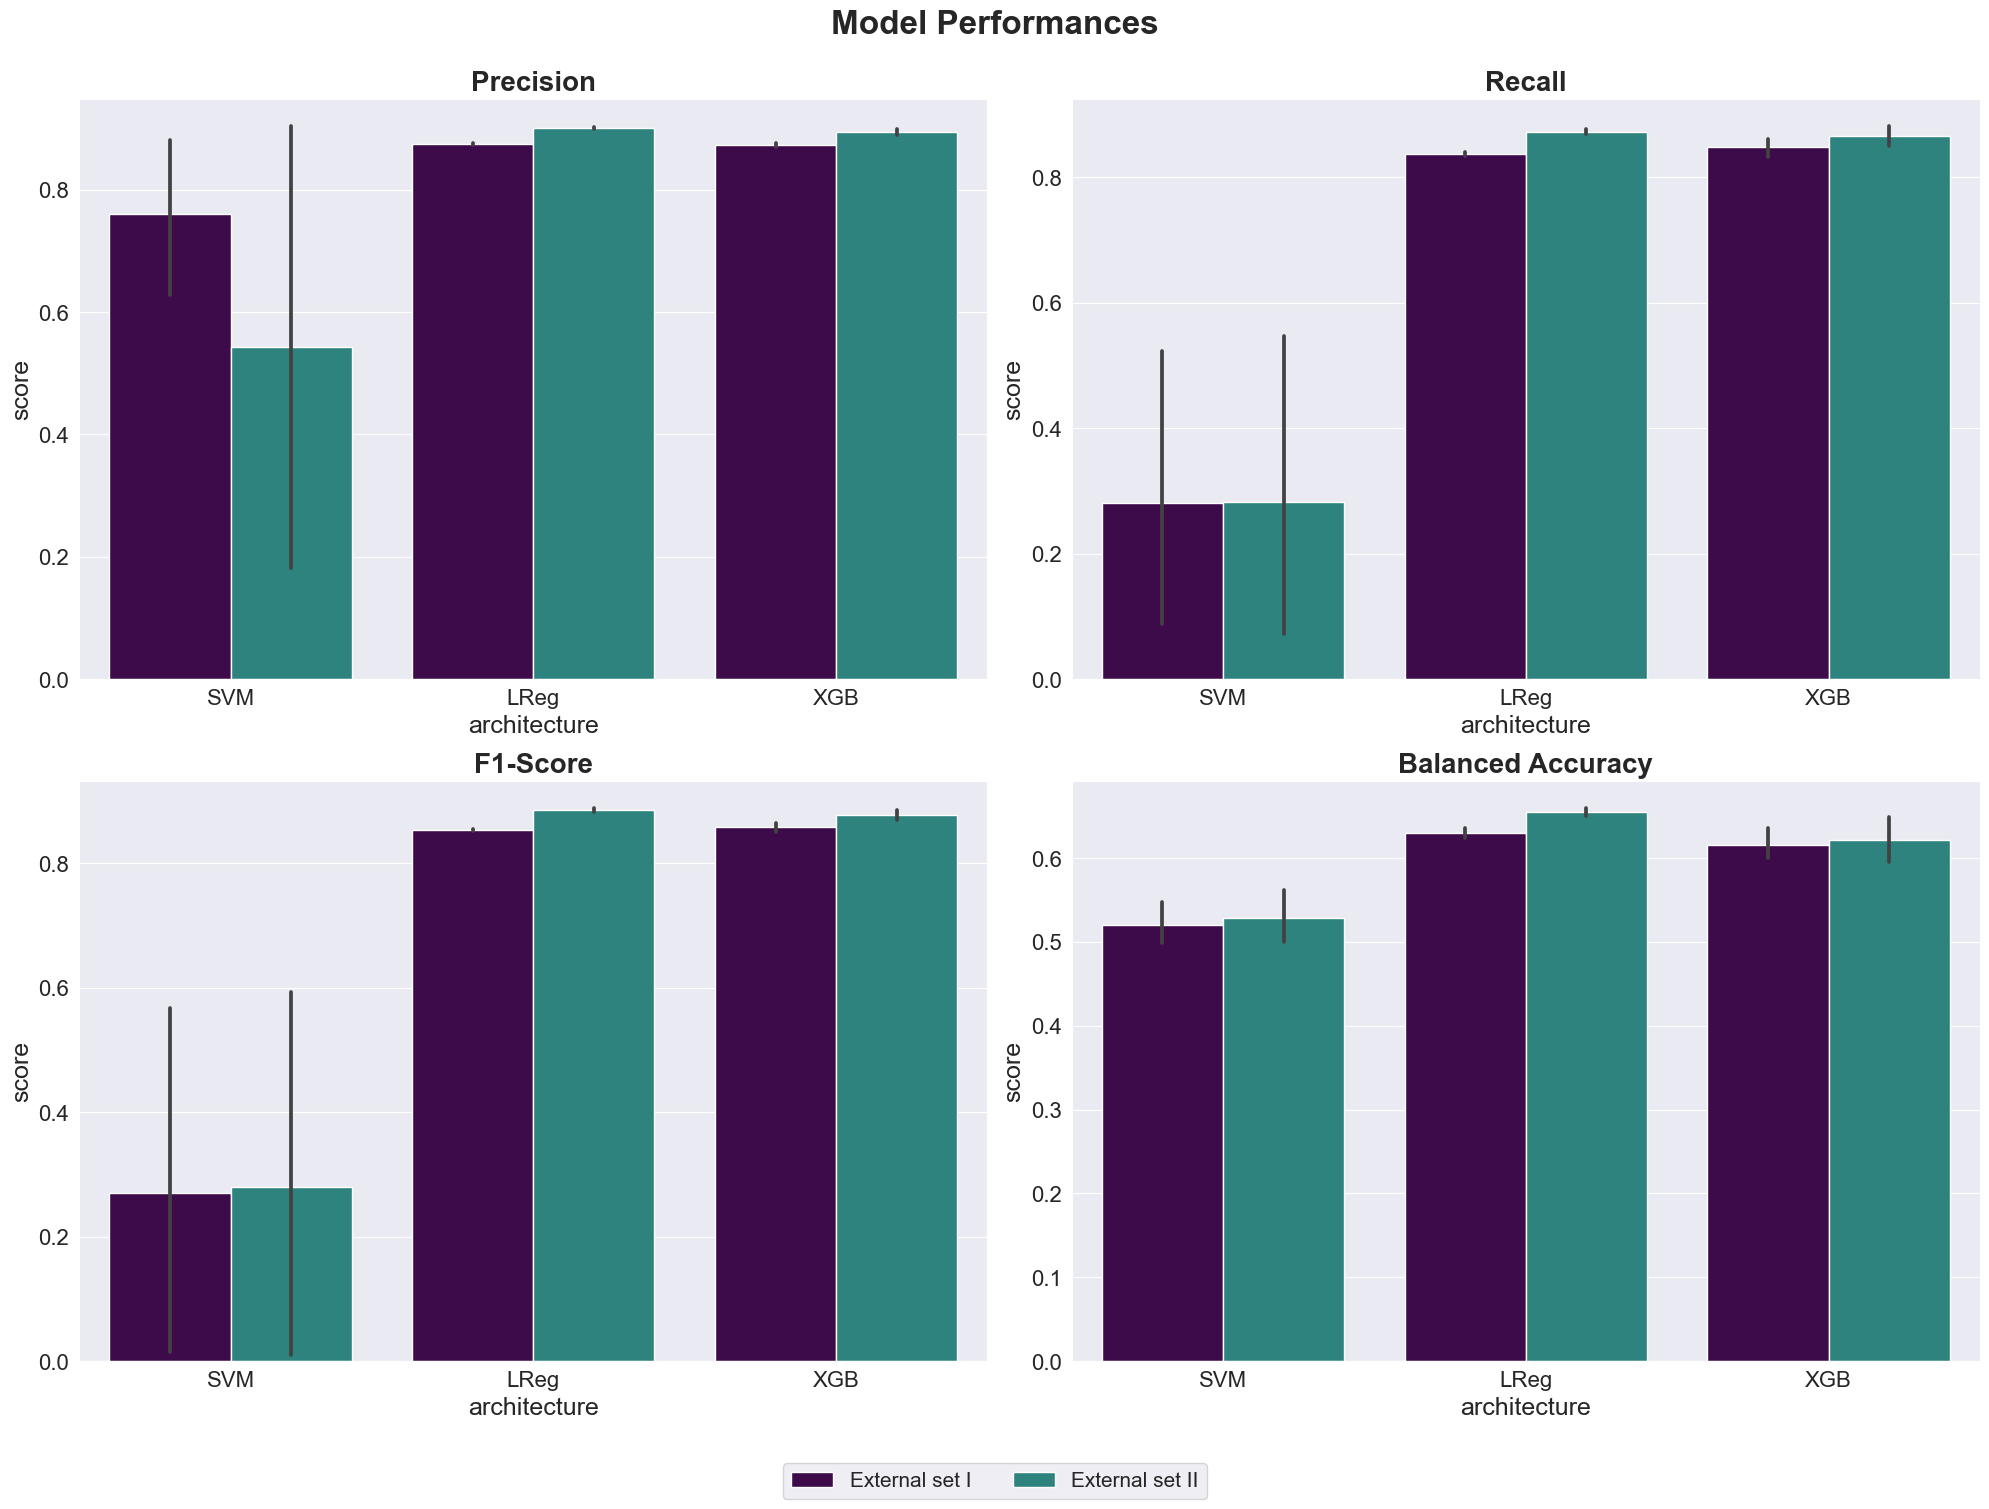

In [59]:
# Remove strings after "_"
df['Model'] = df['Model'].str.split('_').str[0]

# Use the seaborn darkgrid style
sns.set_style("darkgrid")

# List of metrics
metrics = ['Precision', 'Recall', 'F1-Score', 'Balanced Accuracy']

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 15))

handles, labels = None, None

# Custom palette
palette_colors = ['#440154', '#21918C', '#FDE725']

# Loop through each metric and create a subplot for each one
for ax, metric in zip(axes.ravel(), metrics):
    bars = sns.barplot(x='Model', y=metric, hue='Dataset', data=df, ax=ax, palette=palette_colors)
    
    # Bold the metric titles
    ax.set_title(metric, fontsize=20, fontweight='bold')
    
    ax.set_ylabel('score', fontsize=18)
    ax.set_xlabel('architecture', fontsize=18)
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
    ax.legend().set_visible(False)  # hide the individual legend
    
    if handles is None:
        handles, labels = ax.get_legend_handles_labels()

# Add an overall title closer to the subplots
fig.suptitle('Model Performances', fontsize=24, fontweight='bold', y=0.95)

# Add a centralized legend closer to the plots
fig.legend(handles, labels, loc='lower center', ncol=3, fontsize=15, frameon=True, bbox_to_anchor=(0.5, -0.05))

plt.tight_layout(rect=[0, 0, 1, 0.95])
fig.savefig(f'/Users/marinacamacho/Desktop/Master_I/Data_Final/Binary_1/Plots/final_model_performance_plot{DIS}{FET}.png', dpi=300, bbox_inches='tight')
plt.show()

In [60]:
best_model = models[best_model_info_dataset1[0][:-2]][int(best_model_info_dataset1[0][-1:])]
best_feats = trainData.iloc[:,best_model['features']].columns

probs = best_model['model'].predict_proba(X_ext)[:,1]
preds = np.where(probs > best_model['threshold'], 1, 0)
print(classification_report(y_true=y_ext,
                        y_pred=preds))

with open(f"{PAT}/{MOD}/best_model_ext{DIS}{FET}", "wb") as fp:
    pickle.dump(best_model, fp)

              precision    recall  f1-score   support

           0       0.93      0.93      0.93      5127
           1       0.26      0.25      0.25       492

    accuracy                           0.87      5619
   macro avg       0.59      0.59      0.59      5619
weighted avg       0.87      0.87      0.87      5619



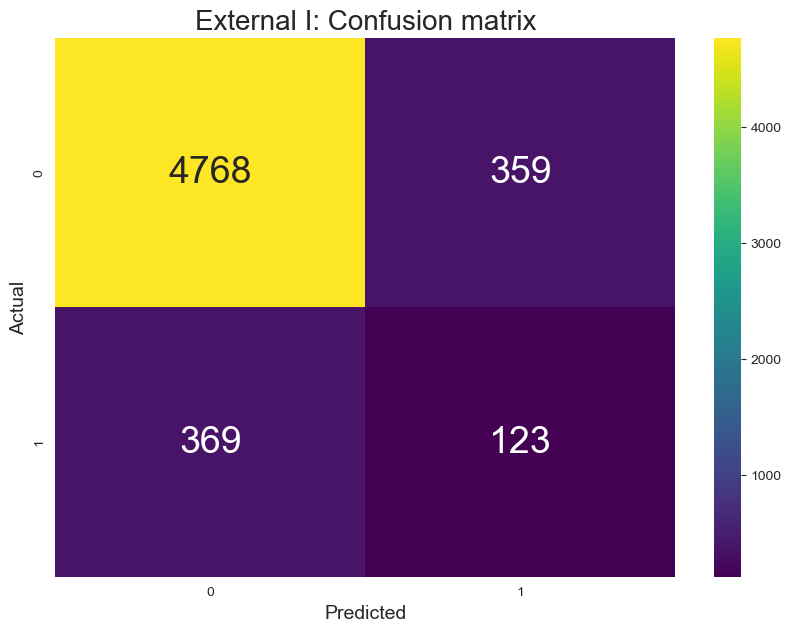

In [61]:
probs = best_model['model'].predict_proba(X_ext)[:,1]
preds = np.where(probs > best_model['threshold'], 1, 0)

cm = confusion_matrix(y_ext, preds) 


plt.figure(figsize=(10,7))
plt.title("External I: Confusion matrix", fontsize=20)
sns.heatmap(cm, annot=True, fmt="d", cmap="viridis", annot_kws={"size": 27})  # Adjust the font size here
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('Actual', fontsize=14)

# Save the figure in high resolution
plt.savefig(f"{PAT}/{MOD}/final_confusion_matrix_ext{DIS}{FET}.png", dpi=300)

plt.show()

In [62]:
probs = best_model['model'].predict_proba(X_trace)[:,1]
preds = np.where(probs > best_model['threshold'], 1, 0)

print(classification_report(y_true=y_trace,
                        y_pred=preds))

with open(f"{PAT}/{MOD}/best_model_trace{DIS}{FET}", "wb") as fp:
    pickle.dump(best_model, fp)

              precision    recall  f1-score   support

           0       0.94      0.94      0.94       633
           1       0.25      0.24      0.25        49

    accuracy                           0.89       682
   macro avg       0.60      0.59      0.59       682
weighted avg       0.89      0.89      0.89       682



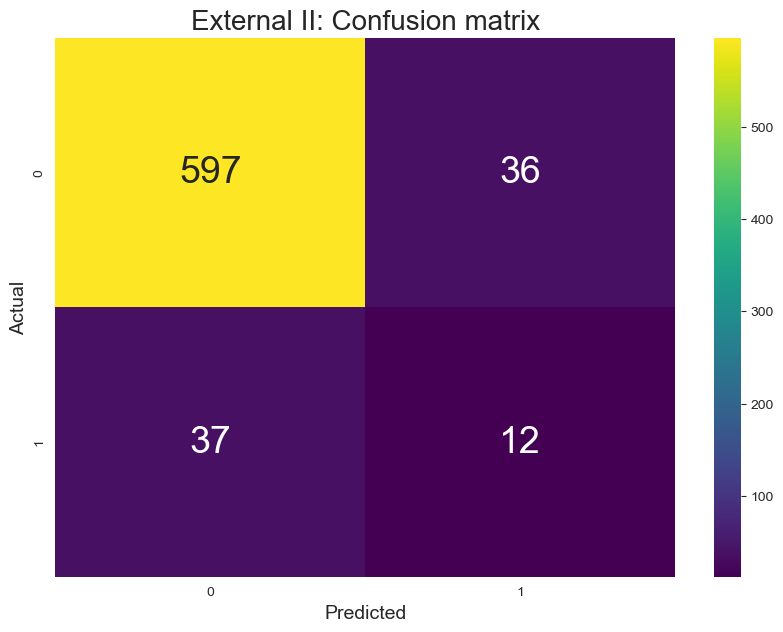

In [63]:
probs = best_model['model'].predict_proba(X_trace)[:,1]
preds = np.where(probs > best_model['threshold'], 1, 0)

cm = confusion_matrix(y_trace, preds) 
plt.figure(figsize=(10,7))
plt.title("External II: Confusion matrix", fontsize=20)
sns.heatmap(cm, annot=True, fmt="d", cmap="viridis", annot_kws={"size": 27})  # Adjust the font size here
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('Actual', fontsize=14)

# Save the figure in high resolution
plt.savefig(f"{PAT}/{MOD}/final_confusion_matrix_trace{DIS}{FET}.png", dpi=300)

plt.show()

In [64]:
best_feats

Index(['APOA', 'APOB', 'Able_to_confide', 'Age', 'BMI', 'Bread_intake', 'CRP',
       'Cereal_intake', 'Cholesterol', 'Coffee_intake',
       'Cooked_vegetable_intake', 'Dried_fruit_intake', 'Fasting_time',
       'Fed-up_feelings', 'Frequency_friend_family_visits',
       'Fresh_fruit_intake', 'Getting_up_in_morning', 'Glucose', 'HDL',
       'HbA1c', 'Hip_circumference', 'IGF_1', 'Loneliness_isolation',
       'Mean_time_to_identify_matches', 'Miserableness', 'Mood_swings',
       'Number_operation', 'Other_serious_condition', 'Overall_health_rating',
       'Salad/raw_vegetable_intake', 'Sleep_duration', 'Standing_height',
       'Suffer_from_nerves', 'Tea_intake', 'Tenseness_2weeks', 'Testosterone',
       'Time_outdoors_summer', 'Time_outdoors_winter', 'Tiredness_2weeks',
       'Triglyceride', 'Unenthusiasm_2weeks', 'Waist_circumference',
       'Water_intake', 'Weekly_phone_use', 'Weight'],
      dtype='object')

In [86]:
# Plot the SHAP values for a single prediction (for example, the first instance)
shap.initjs()

In [87]:
import matplotlib.colors as mcolors

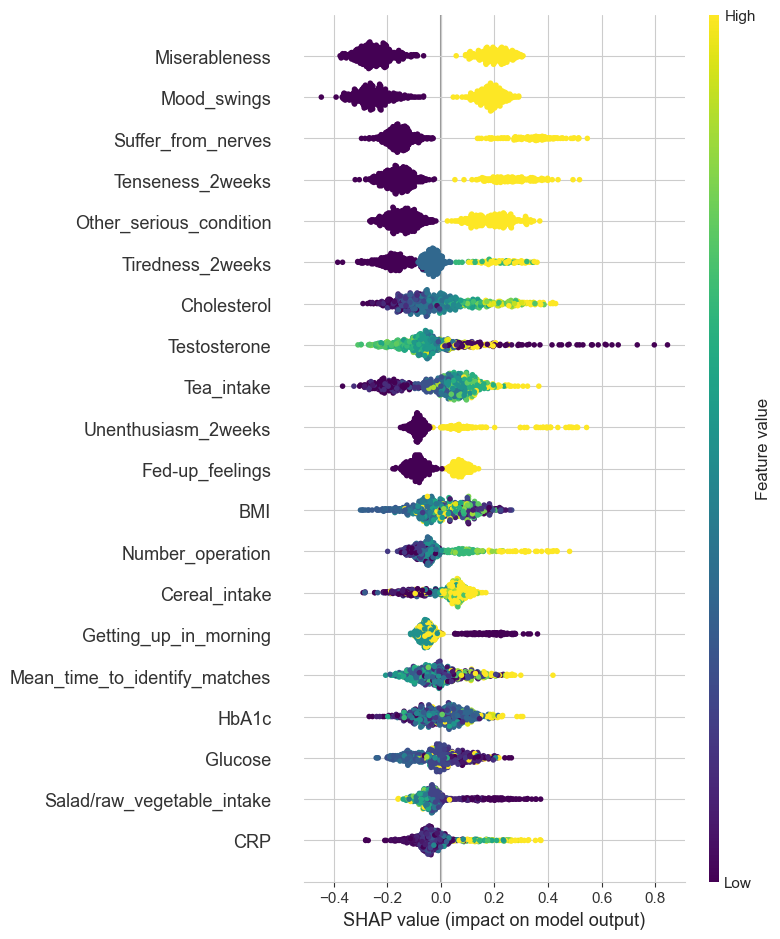

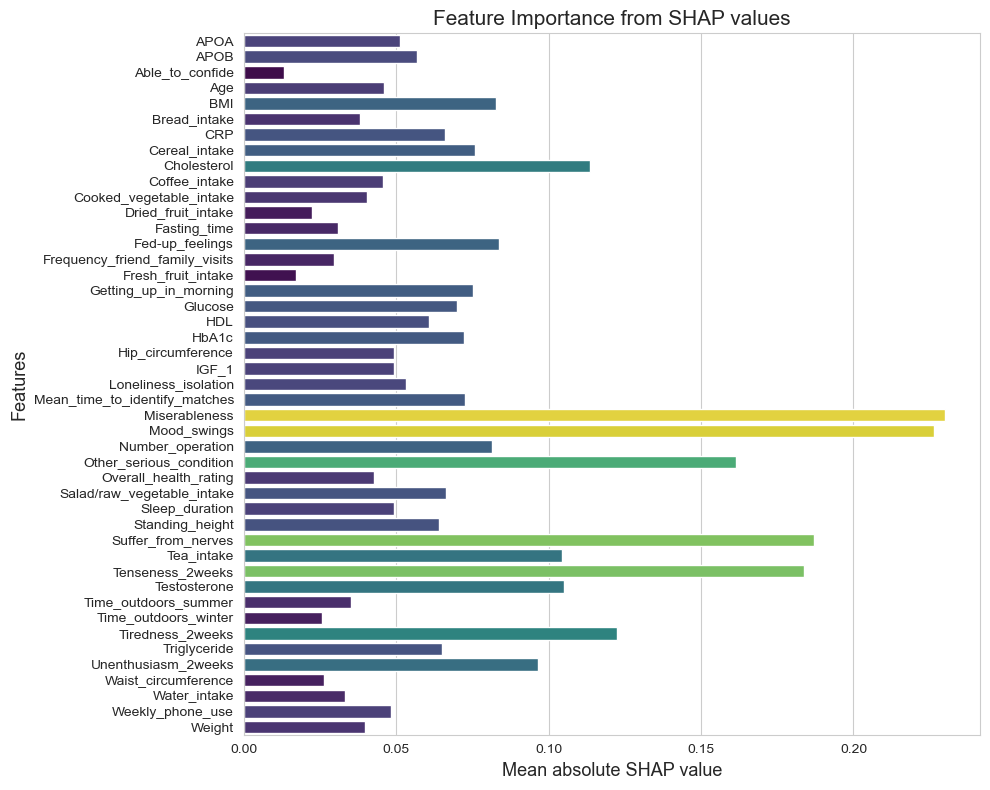

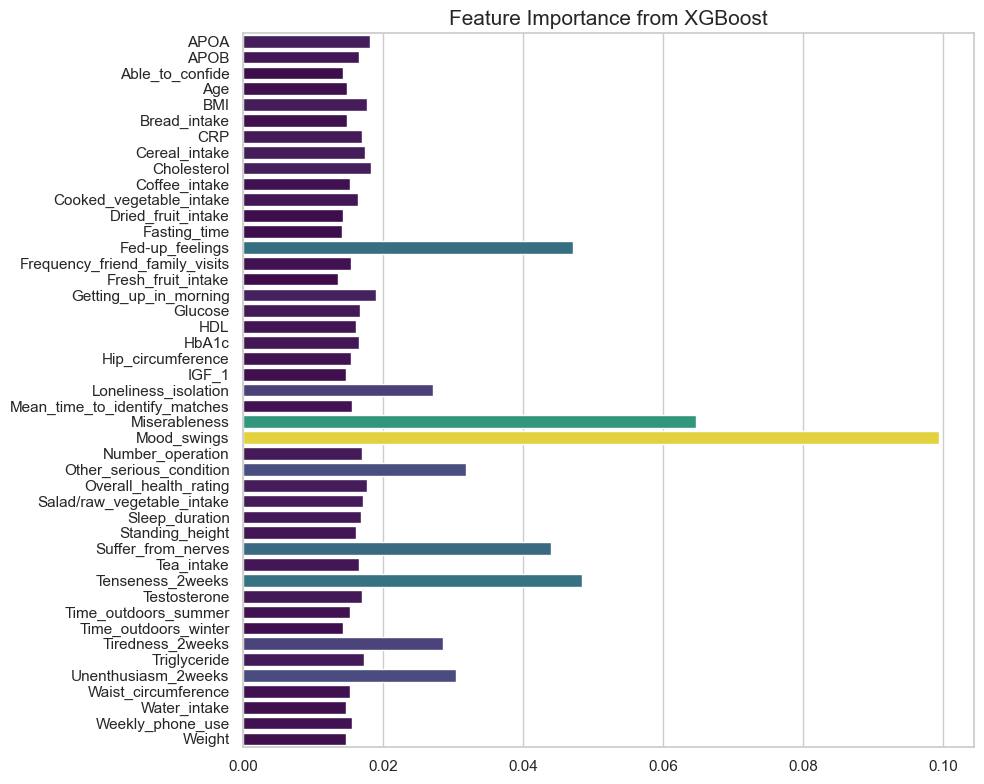

In [92]:
# First, manually apply transformations in the pipeline to the data
X_temp = X_trace.copy()

# Apply imputation
imputer = best_model['model'].named_steps['impute']
X_temp = imputer.transform(X_temp)

# Apply feature selection
selector = best_model['model'].named_steps['select_features']
X_temp = selector.transform(X_temp)

# Now, X_temp contains the transformed data. Use this with the XGB model for SHAP values
xgb_model = best_model['model'].named_steps['XGB']

# Initialize SHAP for the XGB model
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_temp)


#############################################################################
#############################################################################
fig, ax = plt.subplots(figsize=(10, 8))

# Create a colormap that maps from SHAP values to magma colors
max_val = np.abs(shap_values).max()
colors = plt.get_cmap('viridis')  # Change from 'viridis' to 'magma'
shap_colors = [colors(i) for i in np.linspace(0, 1, 256)]
cmap = mcolors.LinearSegmentedColormap.from_list("shap_viridis", shap_colors)  # Rename to "shap_magma"

# Use the created axis in the shap.summary_plot with modified color
shap.summary_plot(shap_values, X_temp, feature_names=list(best_feats), cmap=cmap)

# Now save this figure
fig.tight_layout()
fig.savefig(f'/Users/marinacamacho/Desktop/Master_I/Data_Final/Binary_2/Plots/shap_summary_plot_trace{DIS}{FET}.png', dpi=300)

# And finally show the plot
plt.show()

#############################################################################
#############################################################################
# Compute mean absolute SHAP values for each feature
shap_summary = np.abs(shap_values).mean(axis=0)

# Normalize shap_summary to [0,1]
norm_shap_summary = (shap_summary - min(shap_summary)) / (max(shap_summary) - min(shap_summary))

# Generate color array based on normalized shap values
colors_shap = plt.get_cmap('viridis')(norm_shap_summary)

# Plot
plt.figure(figsize=(10, 8))
sns.barplot(y=best_feats, x=shap_summary, palette=colors_shap)
plt.xlabel('Mean absolute SHAP value', fontsize=13)
plt.ylabel('Features', fontsize=13)
plt.title('Feature Importance from SHAP values', fontsize=15)
plt.tight_layout()
plt.savefig(f'/Users/marinacamacho/Desktop/Master_I/Data_Final/Binary_2/Plots/shap_feature_importance_trace{DIS}{FET}.png', dpi=300)
plt.show()


#############################################################################
#############################################################################
plt.figure(figsize=(10, 8))
sns.set(style="whitegrid")

# Get feature importances and normalize to [0,1]
importances = xgb_model.feature_importances_
norm_importances = (importances - min(importances)) / (max(importances) - min(importances))

# Generate color array based on normalized importance values
colors = plt.get_cmap('viridis')(norm_importances)

# Plot using seaborn's barplot
sns.barplot(y=best_feats, x=importances, palette=colors)
plt.title("Feature Importance from XGBoost", fontsize=15)
plt.tight_layout()
plt.savefig(f'/Users/marinacamacho/Desktop/Master_I/Data_Final/Binary_2/Plots/xgboost_feature_importance_trace{DIS}{FET}.png', dpi=300)
plt.show()

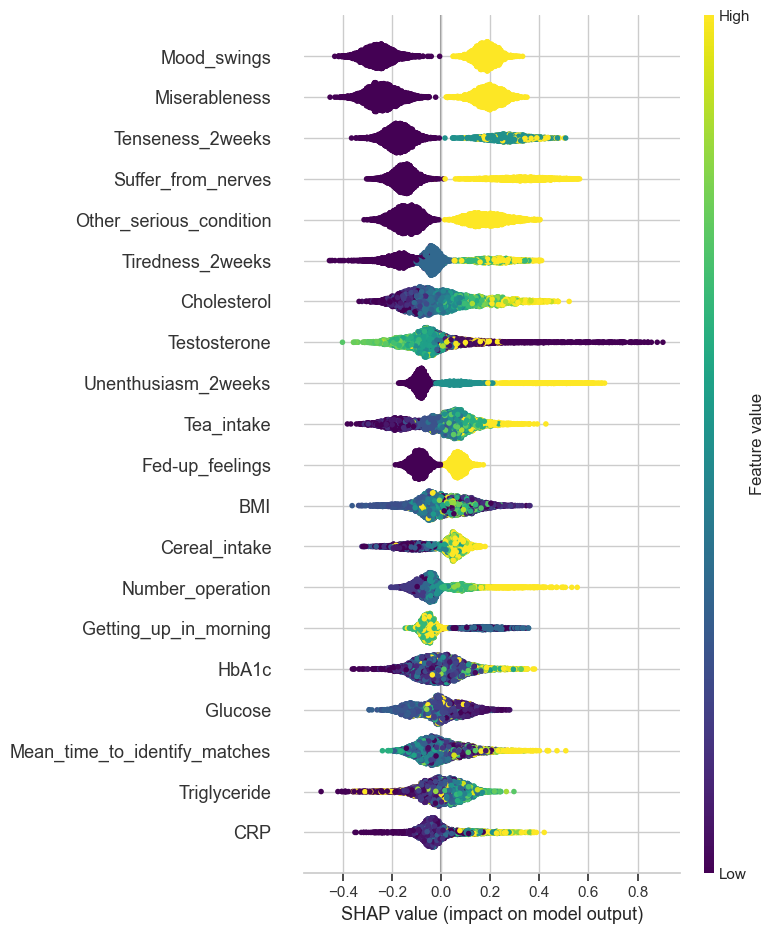

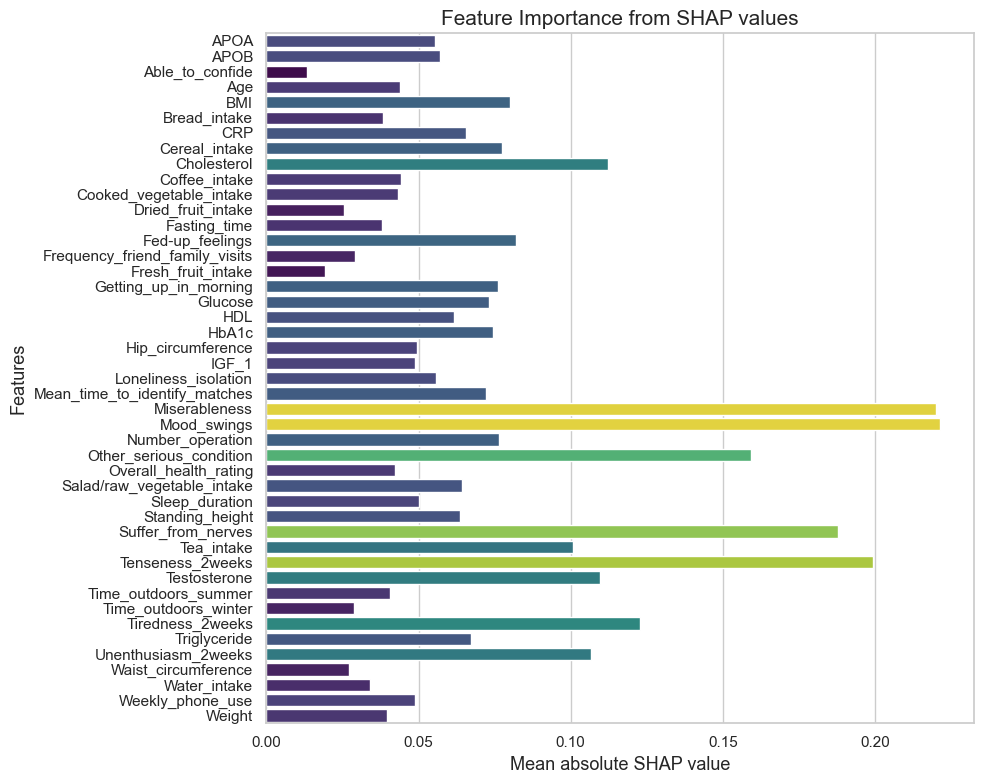

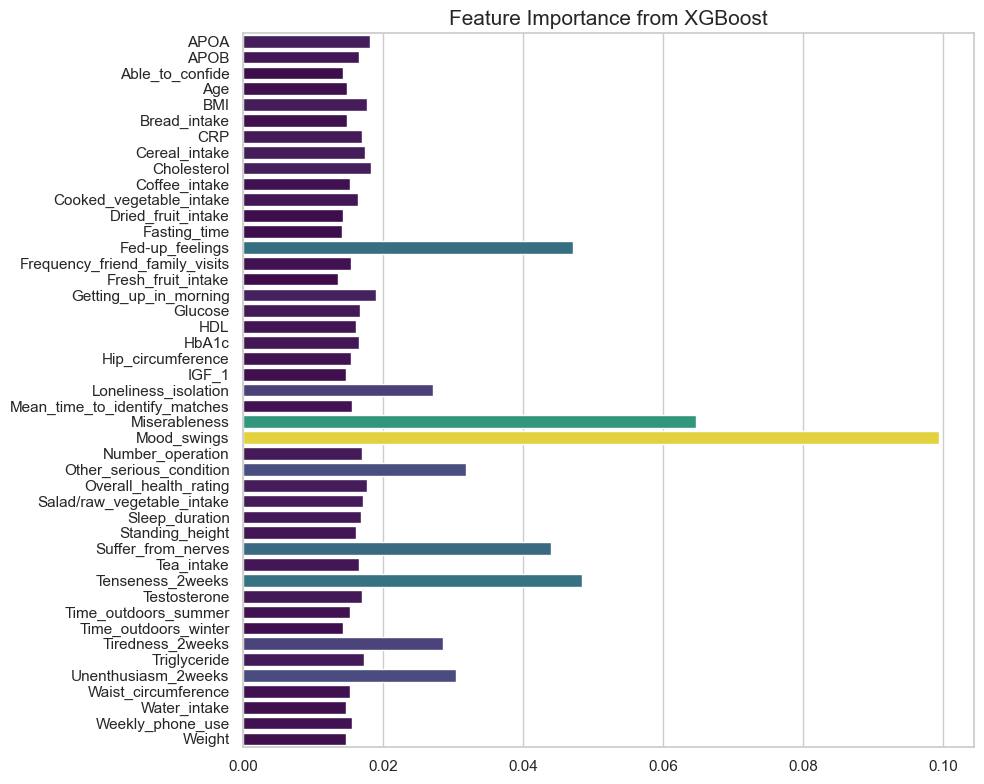

In [93]:
# First, manually apply transformations in the pipeline to the data
X_temp = X_ext.copy()

# Apply imputation
imputer = best_model['model'].named_steps['impute']
X_temp = imputer.transform(X_temp)

# Apply feature selection
selector = best_model['model'].named_steps['select_features']
X_temp = selector.transform(X_temp)

# Now, X_temp contains the transformed data. Use this with the XGB model for SHAP values
xgb_model = best_model['model'].named_steps['XGB']

# Initialize SHAP for the XGB model
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_temp)


#############################################################################
#############################################################################
fig, ax = plt.subplots(figsize=(10, 8))

# Create a colormap that maps from SHAP values to magma colors
max_val = np.abs(shap_values).max()
colors = plt.get_cmap('viridis')  # Change from 'viridis' to 'magma'
shap_colors = [colors(i) for i in np.linspace(0, 1, 256)]
cmap = mcolors.LinearSegmentedColormap.from_list("shap_viridis", shap_colors)  # Rename to "shap_magma"

# Use the created axis in the shap.summary_plot with modified color
shap.summary_plot(shap_values, X_temp, feature_names=list(best_feats), cmap=cmap)

# Now save this figure
fig.tight_layout()
fig.savefig(f'/Users/marinacamacho/Desktop/Master_I/Data_Final/Binary_2/Plots/shap_summary_plot_ext{DIS}{FET}.png', dpi=300)

# And finally show the plot
plt.show()

#############################################################################
#############################################################################
# Compute mean absolute SHAP values for each feature
shap_summary = np.abs(shap_values).mean(axis=0)

# Normalize shap_summary to [0,1]
norm_shap_summary = (shap_summary - min(shap_summary)) / (max(shap_summary) - min(shap_summary))

# Generate color array based on normalized shap values
colors_shap = plt.get_cmap('viridis')(norm_shap_summary)

# Plot
plt.figure(figsize=(10, 8))
sns.barplot(y=best_feats, x=shap_summary, palette=colors_shap)
plt.xlabel('Mean absolute SHAP value', fontsize=13)
plt.ylabel('Features', fontsize=13)
plt.title('Feature Importance from SHAP values', fontsize=15)
plt.tight_layout()
plt.savefig(f'/Users/marinacamacho/Desktop/Master_I/Data_Final/Binary_2/Plots/shap_feature_importance_ext{DIS}{FET}.png', dpi=300)
plt.show()

#############################################################################
#############################################################################
plt.figure(figsize=(10, 8))
sns.set(style="whitegrid")

# Get feature importances and normalize to [0,1]
importances = xgb_model.feature_importances_
norm_importances = (importances - min(importances)) / (max(importances) - min(importances))

# Generate color array based on normalized importance values
colors = plt.get_cmap('viridis')(norm_importances)

# Plot using seaborn's barplot
sns.barplot(y=best_feats, x=importances, palette=colors)
plt.title("Feature Importance from XGBoost", fontsize=15)
plt.tight_layout()
plt.savefig(f'/Users/marinacamacho/Desktop/Master_I/Data_Final/Binary_2/Plots/xgboost_feature_importance_ext{DIS}{FET}.png', dpi=300)
plt.show()

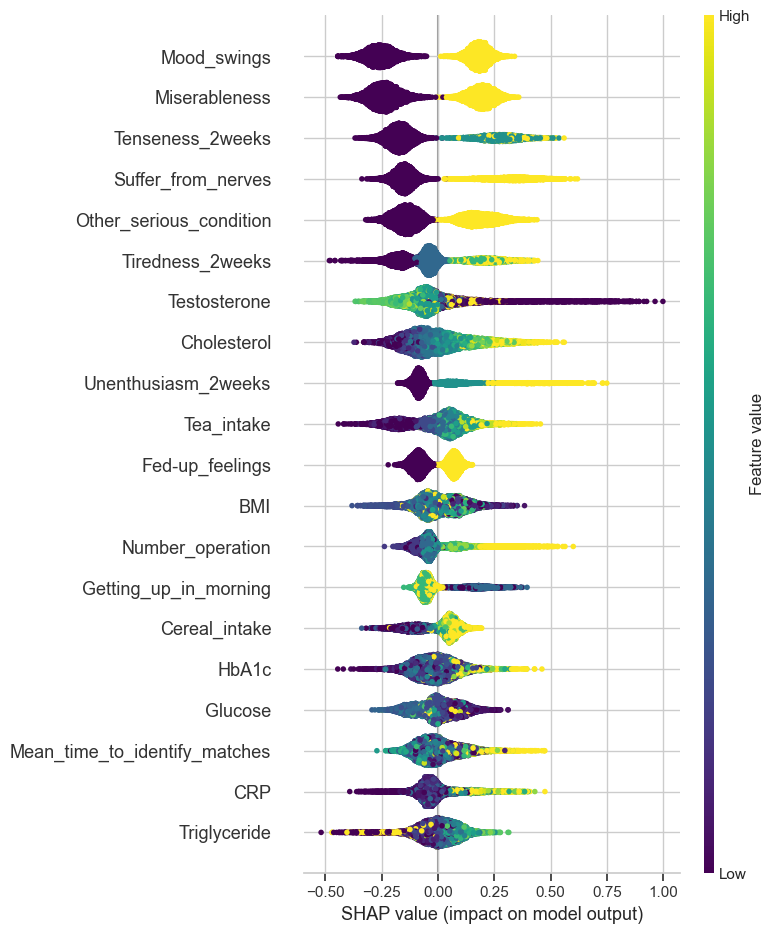

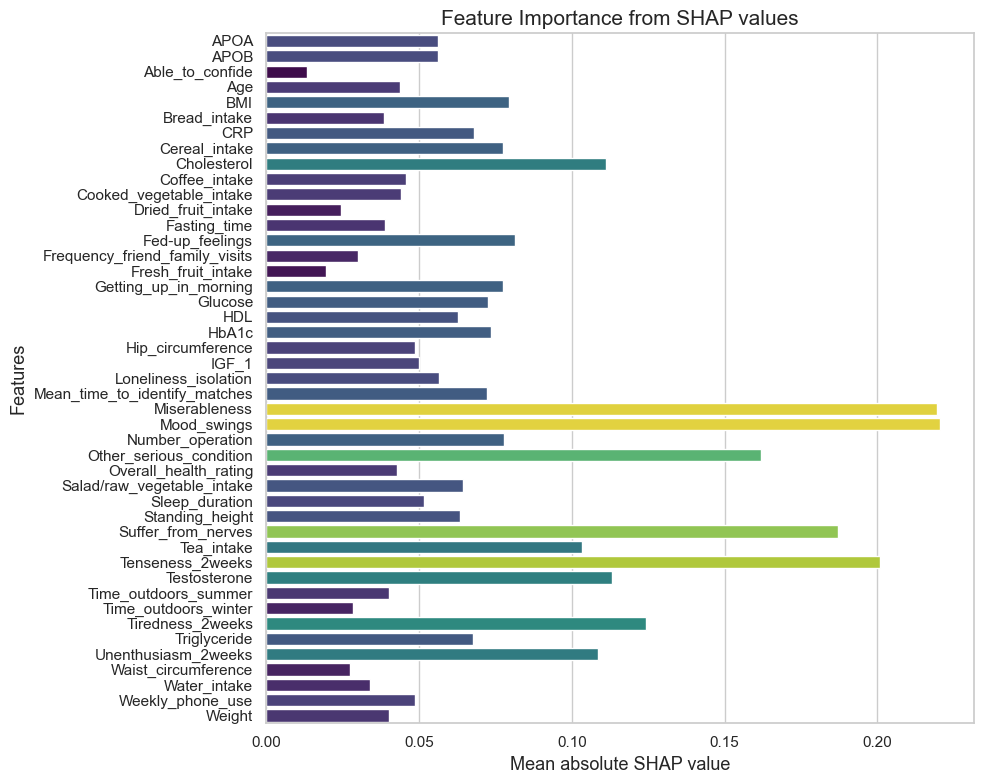

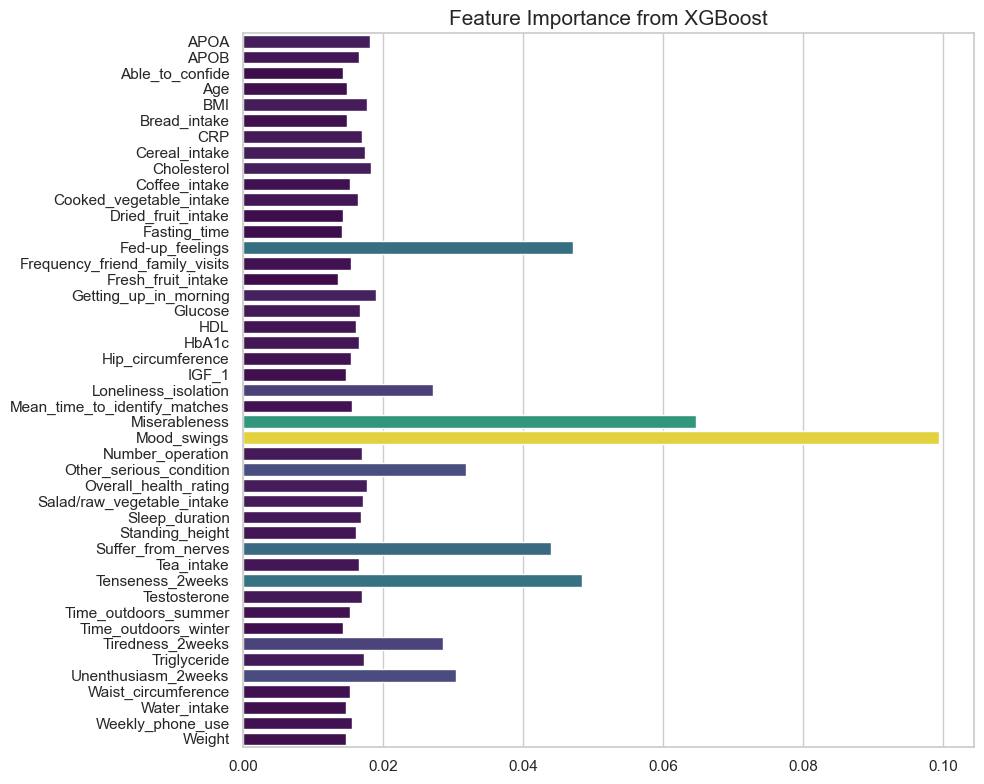

In [94]:
# First, manually apply transformations in the pipeline to the data
X_temp = trainData.copy()

# Apply imputation
imputer = best_model['model'].named_steps['impute']
X_temp = imputer.transform(X_temp)

# Apply feature selection
selector = best_model['model'].named_steps['select_features']
X_temp = selector.transform(X_temp)

# Now, X_temp contains the transformed data. Use this with the XGB model for SHAP values
xgb_model = best_model['model'].named_steps['XGB']

# Initialize SHAP for the XGB model
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_temp)


#############################################################################
#############################################################################
fig, ax = plt.subplots(figsize=(10, 8))

# Create a colormap that maps from SHAP values to magma colors
max_val = np.abs(shap_values).max()
colors = plt.get_cmap('viridis')  # Change from 'viridis' to 'magma'
shap_colors = [colors(i) for i in np.linspace(0, 1, 256)]
cmap = mcolors.LinearSegmentedColormap.from_list("shap_viridis", shap_colors)  # Rename to "shap_magma"

# Use the created axis in the shap.summary_plot with modified color
shap.summary_plot(shap_values, X_temp, feature_names=list(best_feats), cmap=cmap)

# Now save this figure
fig.tight_layout()
fig.savefig(f'/Users/marinacamacho/Desktop/Master_I/Data_Final/Binary_2/Plots/shap_summary_plot_train{DIS}{FET}.png', dpi=300)

# And finally show the plot
plt.show()
#############################################################################
#############################################################################
# Compute mean absolute SHAP values for each feature
shap_summary = np.abs(shap_values).mean(axis=0)

# Normalize shap_summary to [0,1]
norm_shap_summary = (shap_summary - min(shap_summary)) / (max(shap_summary) - min(shap_summary))

# Generate color array based on normalized shap values
colors_shap = plt.get_cmap('viridis')(norm_shap_summary)

# Plot
plt.figure(figsize=(10, 8))
sns.barplot(y=best_feats, x=shap_summary, palette=colors_shap)
plt.xlabel('Mean absolute SHAP value', fontsize=13)
plt.ylabel('Features', fontsize=13)
plt.title('Feature Importance from SHAP values', fontsize=15)
plt.tight_layout()
plt.savefig(f'/Users/marinacamacho/Desktop/Master_I/Data_Final/Binary_2/Plots/shap_feature_importance_train{DIS}{FET}.png', dpi=300)
plt.show()

#############################################################################
#############################################################################
plt.figure(figsize=(10, 8))
sns.set(style="whitegrid")

# Get feature importances and normalize to [0,1]
importances = xgb_model.feature_importances_
norm_importances = (importances - min(importances)) / (max(importances) - min(importances))

# Generate color array based on normalized importance values
colors = plt.get_cmap('viridis')(norm_importances)

# Plot using seaborn's barplot
sns.barplot(y=best_feats, x=importances, palette=colors)
plt.title("Feature Importance from XGBoost", fontsize=15)
plt.tight_layout()
plt.savefig(f'/Users/marinacamacho/Desktop/Master_I/Data_Final/Binary_2/Plots/xgboost_feature_importance_train{DIS}{FET}.png', dpi=300)
plt.show()

In [65]:
LOAD = "/Users/marinacamacho/Desktop/Master_I/Raw_Data"
Cols = ["f.eid","Ethnic", "Skin_colour", "Sex"]
# Exposome data
fair = pd.read_csv(f'{LOAD}/Time_0/all_exposome_0.csv', usecols=lambda col: col in Cols)
fair = fair.set_index('f.eid')
fair = fair.sort_index(axis=1)
fair.index.name = 'eid'

fair2 = pd.read_csv(f'{LOAD}/Time_1/all_exposome_1.csv', usecols=lambda col: col in Cols)
fair2 = fair2.set_index('f.eid')
fair2 = fair2.sort_index(axis=1)
fair2.index.name = 'eid'

fair['Skin_colour'] = fair['Skin_colour'].replace([1,2,3,4,5,6,-1,-3],[0,0,0,0,1,1,np.nan,np.nan])   
fair2['Skin_colour'] = fair2['Skin_colour'].replace([1,2,3,4,5,6,-1,-3],[0,0,0,0,1,1,np.nan,np.nan])    

fair['Ethnic'] = fair['Ethnic'].replace([1,1001,1002,1003],[0,0,0,0])   
fair['Ethnic'] = fair['Ethnic'].replace([2,2001,2002,2003,2004,3,3001,3002,3003,3004,4,4001,4002,4003,5],[1,1,1,1,1,1,1,1,1,1,1,1,1,1,1])   
fair['Ethnic'] = fair['Ethnic'].replace([6,-1,-3],[np.nan,np.nan,np.nan])   

fair2['Ethnic'] = fair2['Ethnic'].replace([1,1001,1002,1003],[0,0,0,0])   
fair2['Ethnic'] = fair2['Ethnic'].replace([2,2001,2002,2003,2004,3,3001,3002,3003,3004,4,4001,4002,4003,5],[1,1,1,1,1,1,1,1,1,1,1,1,1,1,1])   
fair2['Ethnic'] = fair2['Ethnic'].replace([6,-1,-3],[np.nan,np.nan,np.nan])

fair_trace = fair2[fair2.index.isin(traceCohort.index)]
fair_ext = fair[fair.index.isin(extCohort.index)]
fair_train = fair[fair.index.isin(trainData.index)]

In [66]:
def fairness_metrics_with_fairlearn(predictions, actuals, protected):
    # Convert to numpy arrays for consistency
    predictions = np.array(predictions)
    actuals = np.array(actuals)
    protected = np.array(protected)

    # Verify that shapes match
    assert protected.shape == actuals.shape == predictions.shape, "Shapes of inputs do not match"

    # Demographic Parity Difference
    demo_parity_diff = demographic_parity_difference(y_true=actuals, y_pred=predictions, sensitive_features=protected)
    
    # Equalized Odds Difference: 
    # This combines both the true positive rate difference and the false positive rate difference.
    equal_opportunity_diff = equalized_odds_difference(y_true=actuals, y_pred=predictions, sensitive_features=protected)
    
    # False Positive Rate Difference
    fp_rate_diff = false_positive_rate_difference(y_true=actuals, y_pred=predictions, sensitive_features=protected)
    
    # False Negative Rate Difference
    fn_rate_diff = false_negative_rate_difference(y_true=actuals, y_pred=predictions, sensitive_features=protected)

    # Note: `fairlearn` does not provide a specific function for True Negative Rate Difference, 
    # but it can be calculated as 1 - FP Rate for each group, and then the difference can be found.
    
    return demo_parity_diff, equal_opportunity_diff, fp_rate_diff, fn_rate_diff

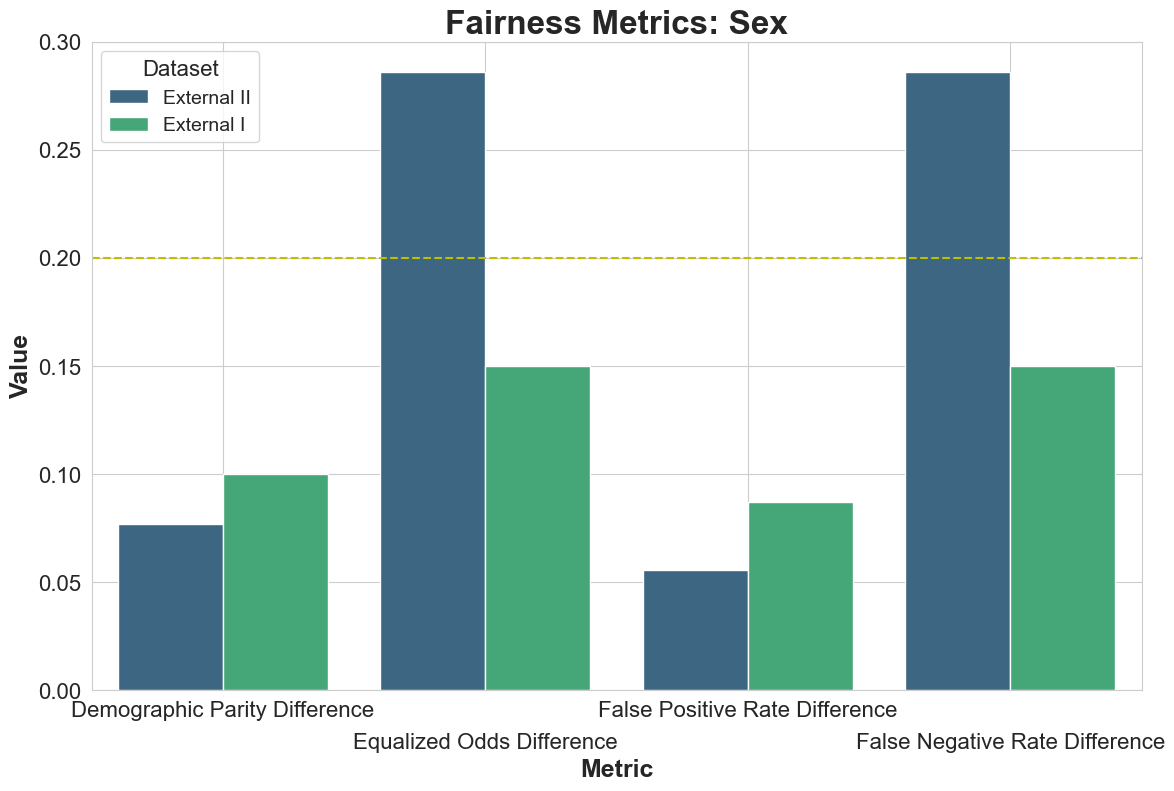

In [67]:
fair_trace_list = fair_trace['Sex']
fair_ext_list = fair_ext['Sex']

# Predict probabilities for the trace and external datasets
probs = best_model['model'].predict_proba(X_trace)[:,1]
probs_trace = np.where(probs > best_model['threshold'], 1, 0)

probs = best_model['model'].predict_proba(X_ext)[:,1]
probs_ext = np.where(probs > best_model['threshold'], 1, 0)

# Compute fairness metrics for both datasets using the function from fairlearn
metrics_trace = fairness_metrics_with_fairlearn(probs_trace, np.array(y_trace).flatten(), fair_trace_list)
metrics_ext = fairness_metrics_with_fairlearn(probs_ext, np.array(y_ext).flatten(), fair_ext_list)

metrics_names = [
    "Demographic Parity Difference", 
    "Equalized Odds Difference", 
    "False Positive Rate Difference", 
    "False Negative Rate Difference"
]

# Create a DataFrame for easier plotting
df = pd.DataFrame({
    'Metric': metrics_names * 2,
    'Value': metrics_trace + metrics_ext,
    'Dataset': ['External II'] * len(metrics_names) + ['External I'] * len(metrics_names)
})


# Plotting
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")
sns.barplot(data=df, x='Metric', y='Value', hue='Dataset', palette='viridis')

# Set plot details
plt.ylim(0, 0.30)
plt.title('Fairness Metrics: Sex', fontsize=24, fontweight='bold')
plt.xlabel('Metric', fontsize=18, fontweight='bold')
plt.ylabel('Value', fontsize=18, fontweight='bold')
plt.grid(axis='y')
plt.grid(True)
plt.legend(title='Dataset', fontsize=14, title_fontsize=16)

# Adjust x-tick labels for staggering and increase their size
locs, labels = plt.xticks()  # get the current tick locations and labels
plt.setp(labels, rotation=0, fontsize=16)  # set the x-tick labels rotation to 45 degrees and align to the right
for i, label in enumerate(labels):
    position = label.get_position()
    if i % 2 == 0:  # if even index, adjust y-position to be lower
        label.set_position((position[0], position[1]))
    else:  # if odd index, adjust y-position to be higher
        label.set_position((position[0], position[1] - 0.05))

# Adjust the y-tick labels size
plt.yticks(fontsize=16)

# Save the plot
plt.tight_layout()

# Add horizontal lines at y=0.2 and y=-0.2
plt.axhline(y=0.2, color='y', linestyle='--')
#plt.axhline(y=-0.2, color='y', linestyle='--')

plt.savefig(f'/Users/marinacamacho/Desktop/Master_I/Data_Final/Binary_1/Plots/fairness_sex_plot_combined{DIS}{FET}.png', dpi=300)

# Show the plot
plt.show()

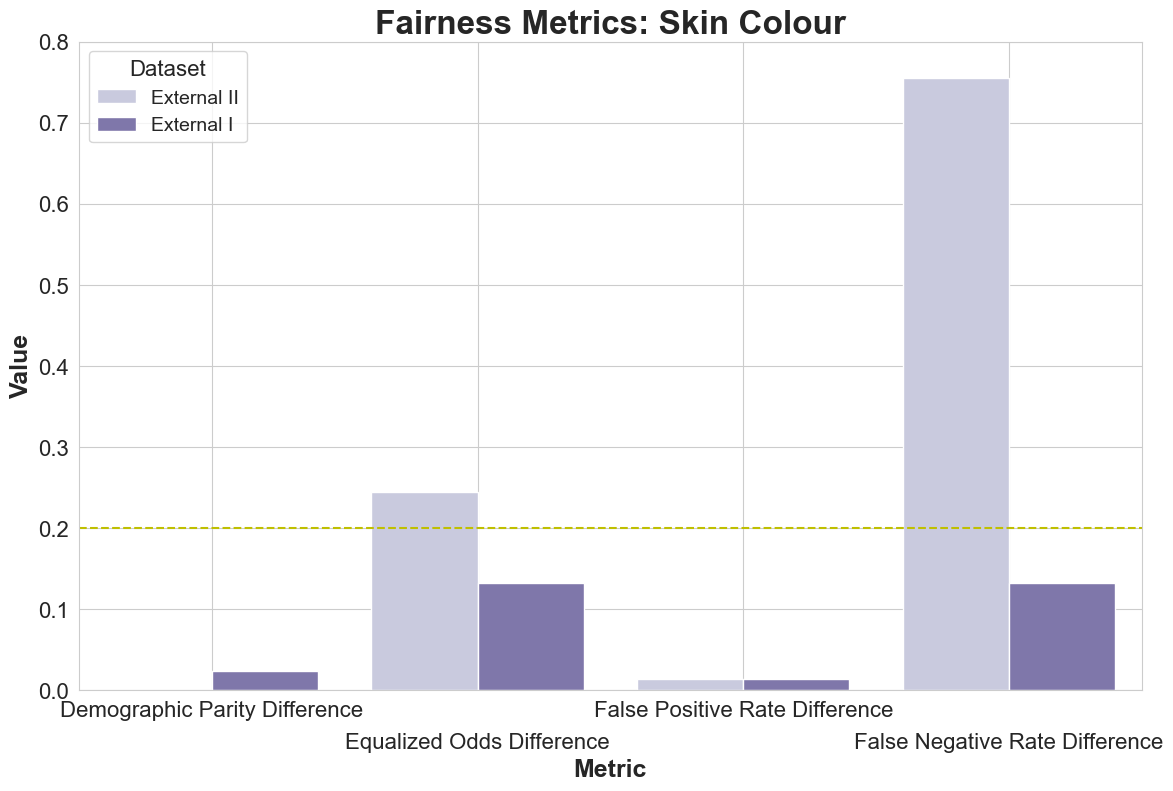

In [68]:
fair_trace_list = fair_trace['Skin_colour']
fair_ext_list = fair_ext['Skin_colour']

# Predict probabilities for the trace and external datasets
probs = best_model['model'].predict_proba(X_trace)[:,1]
probs_trace = np.where(probs > best_model['threshold'], 1, 0)

probs = best_model['model'].predict_proba(X_ext)[:,1]
probs_ext = np.where(probs > best_model['threshold'], 1, 0)

# Convert to numpy arrays
probs_trace = np.array(probs_trace)
y_trace = np.array(y_trace).flatten()
fair_trace_list = np.array(fair_trace_list)

probs_ext = np.array(probs_ext)
y_ext = np.array(y_ext).flatten()
fair_ext_list = np.array(fair_ext_list)

# Identify non-NaN indices for trace
non_nan_indices_trace = ~np.isnan(probs_trace) & ~np.isnan(y_trace) & ~np.isnan(fair_trace_list)

# Filter out NaN values for trace
probs_trace_clean = probs_trace[non_nan_indices_trace]
y_trace_clean = y_trace[non_nan_indices_trace]
fair_trace_list_clean = fair_trace_list[non_nan_indices_trace]

# Identify non-NaN indices for ext
non_nan_indices_ext = ~np.isnan(probs_ext) & ~np.isnan(y_ext) & ~np.isnan(fair_ext_list)

# Filter out NaN values for ext
probs_ext_clean = probs_ext[non_nan_indices_ext]
y_ext_clean = y_ext[non_nan_indices_ext]
fair_ext_list_clean = fair_ext_list[non_nan_indices_ext]

# Now, compute the fairness metrics using the cleaned data
metrics_trace = fairness_metrics_with_fairlearn(probs_trace_clean, y_trace_clean, fair_trace_list_clean)
metrics_ext = fairness_metrics_with_fairlearn(probs_ext_clean, y_ext_clean, fair_ext_list_clean)

metrics_names = [
    "Demographic Parity Difference", 
    "Equalized Odds Difference", 
    "False Positive Rate Difference", 
    "False Negative Rate Difference"
]

# Create a DataFrame for easier plotting
df = pd.DataFrame({
    'Metric': metrics_names * 2,
    'Value': metrics_trace + metrics_ext,
    'Dataset': ['External II'] * len(metrics_names) + ['External I'] * len(metrics_names)
})


# Plotting
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")
sns.barplot(data=df, x='Metric', y='Value', hue='Dataset', palette='Purples')

# Set plot details
plt.ylim(0, 0.8)
plt.title('Fairness Metrics: Skin Colour', fontsize=24, fontweight='bold')
plt.xlabel('Metric', fontsize=18, fontweight='bold')
plt.ylabel('Value', fontsize=18, fontweight='bold')
plt.grid(axis='y')
plt.grid(True)
plt.legend(title='Dataset', fontsize=14, title_fontsize=16)

# Adjust x-tick labels for staggering and increase their size
locs, labels = plt.xticks()  # get the current tick locations and labels
plt.setp(labels, rotation=0, fontsize=16)  # set the x-tick labels rotation to 45 degrees and align to the right
for i, label in enumerate(labels):
    position = label.get_position()
    if i % 2 == 0:  # if even index, adjust y-position to be lower
        label.set_position((position[0], position[1]))
    else:  # if odd index, adjust y-position to be higher
        label.set_position((position[0], position[1] - 0.05))

# Adjust the y-tick labels size
plt.yticks(fontsize=16)

# Save the plot
plt.tight_layout()

# Add horizontal lines at y=0.2 and y=-0.2
plt.axhline(y=0.2, color='y', linestyle='--')
#plt.axhline(y=-0.2, color='y', linestyle='--')

plt.savefig(f'/Users/marinacamacho/Desktop/Master_I/Data_Final/Binary_1/Plots/fairness_skin_plot_combined{DIS}{FET}.png', dpi=300)

# Show the plot
plt.show()

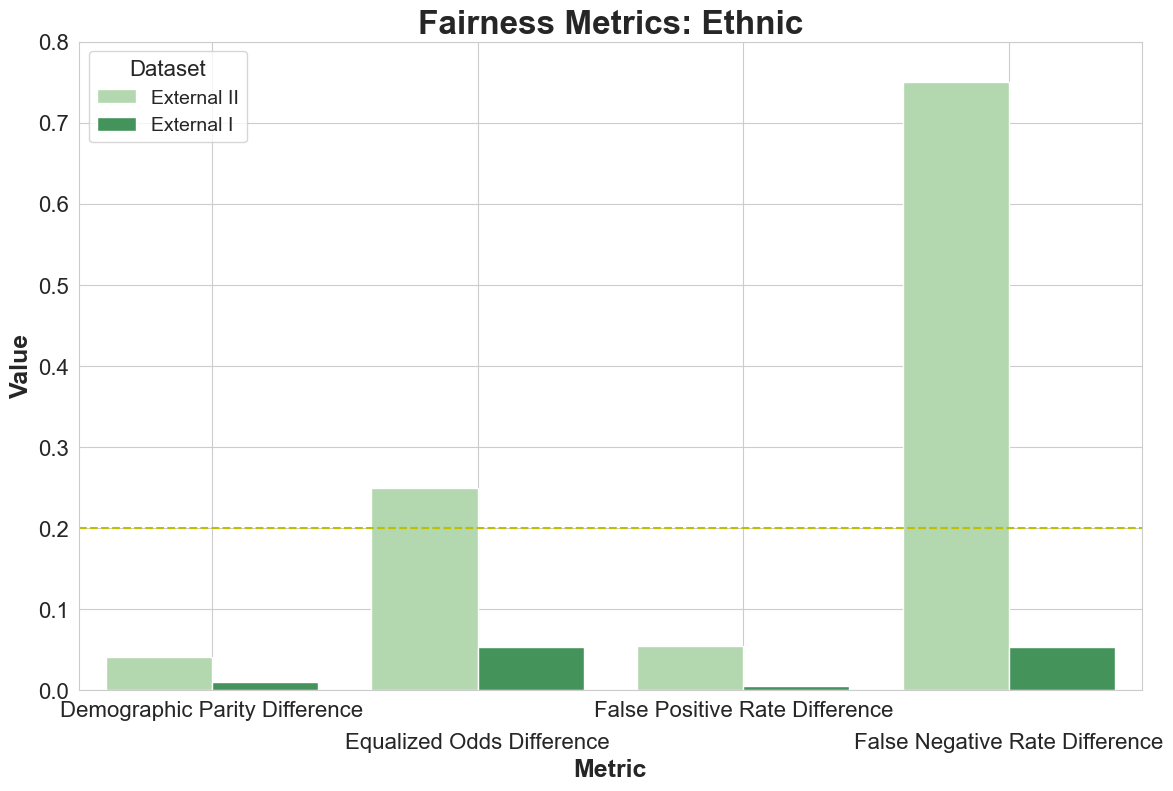

In [69]:
fair_trace_list = fair_trace['Ethnic']
fair_ext_list = fair_ext['Ethnic']

# Predict probabilities for the trace and external datasets
probs = best_model['model'].predict_proba(X_trace)[:,1]
probs_trace = np.where(probs > best_model['threshold'], 1, 0)

probs = best_model['model'].predict_proba(X_ext)[:,1]
probs_ext = np.where(probs > best_model['threshold'], 1, 0)

# Convert to numpy arrays
probs_trace = np.array(probs_trace)
y_trace = np.array(y_trace).flatten()
fair_trace_list = np.array(fair_trace_list)

probs_ext = np.array(probs_ext)
y_ext = np.array(y_ext).flatten()
fair_ext_list = np.array(fair_ext_list)

# Identify non-NaN indices for trace
non_nan_indices_trace = ~np.isnan(probs_trace) & ~np.isnan(y_trace) & ~np.isnan(fair_trace_list)

# Filter out NaN values for trace
probs_trace_clean = probs_trace[non_nan_indices_trace]
y_trace_clean = y_trace[non_nan_indices_trace]
fair_trace_list_clean = fair_trace_list[non_nan_indices_trace]

# Identify non-NaN indices for ext
non_nan_indices_ext = ~np.isnan(probs_ext) & ~np.isnan(y_ext) & ~np.isnan(fair_ext_list)

# Filter out NaN values for ext
probs_ext_clean = probs_ext[non_nan_indices_ext]
y_ext_clean = y_ext[non_nan_indices_ext]
fair_ext_list_clean = fair_ext_list[non_nan_indices_ext]

# Now, compute the fairness metrics using the cleaned data
metrics_trace = fairness_metrics_with_fairlearn(probs_trace_clean, y_trace_clean, fair_trace_list_clean)
metrics_ext = fairness_metrics_with_fairlearn(probs_ext_clean, y_ext_clean, fair_ext_list_clean)

metrics_names = [
    "Demographic Parity Difference", 
    "Equalized Odds Difference", 
    "False Positive Rate Difference", 
    "False Negative Rate Difference"
]

# Note: I removed "True Negative Rate Difference" from metrics_names as it's not directly computed using fairlearn.

# Create a DataFrame for easier plotting
df = pd.DataFrame({
    'Metric': metrics_names * 2,
    'Value': metrics_trace + metrics_ext,
    'Dataset': ['External II'] * len(metrics_names) + ['External I'] * len(metrics_names)
})


# Plotting
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")
sns.barplot(data=df, x='Metric', y='Value', hue='Dataset', palette='Greens')

# Set plot details
plt.ylim(0, 0.8)
plt.title('Fairness Metrics: Ethnic', fontsize=24, fontweight='bold')
plt.xlabel('Metric', fontsize=18, fontweight='bold')
plt.ylabel('Value', fontsize=18, fontweight='bold')
plt.grid(axis='y')
plt.grid(True)
plt.legend(title='Dataset', fontsize=14, title_fontsize=16)

# Adjust x-tick labels for staggering and increase their size
locs, labels = plt.xticks()  # get the current tick locations and labels
plt.setp(labels, rotation=0, fontsize=16)  # set the x-tick labels rotation to 45 degrees and align to the right
for i, label in enumerate(labels):
    position = label.get_position()
    if i % 2 == 0:  # if even index, adjust y-position to be lower
        label.set_position((position[0], position[1]))
    else:  # if odd index, adjust y-position to be higher
        label.set_position((position[0], position[1] - 0.05))

# Adjust the y-tick labels size
plt.yticks(fontsize=16)

# Save the plot
plt.tight_layout()

# Add horizontal lines at y=0.2 and y=-0.2
plt.axhline(y=0.2, color='y', linestyle='--')
#plt.axhline(y=-0.2, color='y', linestyle='--')

plt.savefig(f'/Users/marinacamacho/Desktop/Master_I/Data_Final/Binary_1/Plots/fairness_ethnic_plot_combined{DIS}{FET}.png', dpi=300)

# Show the plot
plt.show()